# Student Success Prediction with Deep Learning (Databricks + OULAD)

## Introduction
This project builds an end-to-end **Student Success Prediction** pipeline using the **Open University Learning Analytics Dataset (OULAD)**. The objective is to predict whether a student will achieve a successful final outcome (binary label) using:

- **Demographics** (e.g., age band, education level, disability, region)
- **Assessment behavior** (submissions and early marks where available)
- **Virtual Learning Environment (VLE)** interactions (clickstream activity across learning resources)

The implementation is designed for **reproducibility and portfolio-quality documentation**:
- Data ingestion and modeling are executed in **Databricks** using **Unity Catalog** tables.
- Feature engineering is expressed as **Bronze → Silver → Gold** layers.
- Models include a **baseline** (Logistic Regression) and a **Deep Learning** model (Keras embeddings for categorical features + numeric features).
- Evaluation includes both a **random split** and a **time-based split** to test generalization to future cohorts.

## Project Goal
Produce a deployable, auditable workflow that can support early identification of at-risk students and demonstrate a production-style ML process suitable for GitHub publication.

## Dataset Reference
Kuzilek J., Hlosta M., Zdrahal Z. *Open University Learning Analytics dataset*. Sci Data 4:170171 (2017).  
License: **CC BY 4.0**


## Table of Contents
1. [Environment and Conventions](#environment-and-conventions)  
2. [Data Assets and Table Inventory](#data-assets-and-table-inventory)  
3. [Bronze Layer: Raw Ingestion](#bronze-layer-raw-ingestion)  
4. [Silver Layer: Cleaning and Standardization](#silver-layer-cleaning-and-standardization)  
5. [Gold Layer: Feature Engineering](#gold-layer-feature-engineering)  
6. [Modeling Strategy](#modeling-strategy)  
7. [Evaluation Protocols](#evaluation-protocols)  
   - [Random Split (Standard)](#random-split-standard)  
   - [Time-Based Split (Future Cohorts)](#time-based-split-future-cohorts)  
8. [Results Summary](#results-summary)  
9. [MLflow Tracking and Artifacts](#mlflow-tracking-and-artifacts)  
10. [Limitations, Risks, and Ethics](#limitations-risks-and-ethics)  
11. [Next Steps](#next-steps)


## Environment and Conventions

### Runtime
This notebook is executed in **Databricks** with:
- Unity Catalog enabled (tables stored under `workspace.*`)
- Python notebook language
- MLflow enabled for experiment tracking

### Naming Conventions
This project uses a layered data pattern:

- **Bronze**: raw ingested tables  
  `workspace.oulad_bronze.*`

- **Silver**: cleaned / standardized tables  
  `workspace.oulad_silver.*` (optional, depending on project scope)

- **Gold**: curated feature tables for modeling  
  `workspace.oulad_gold.*`

### Reproducibility
- All splits and transformations are deterministic where feasible.
- Any random processes (sampling, train/val/test split) should set a fixed seed.


## Data Assets and Table Inventory

### Source Files (CSV)
The OULAD dataset is provided as the following CSV files:

- `assessments.csv` — assessment definitions per module presentation (type, date, weight)
- `courses.csv` — list of module presentations
- `studentAssessment.csv` — student assessment submissions and scores
- `studentInfo.csv` — student demographics + final outcome (target source)
- `studentRegistration.csv` — registration and withdrawal dates
- `studentVle.csv` — student click activity by VLE site and date
- `vle.csv` — VLE site metadata (activity type, identifiers)

### Bronze Tables (Unity Catalog)
After ingestion, each CSV is stored as a Bronze table:

| CSV File | Bronze Table | Primary Keys / Join Fields (typical) | Purpose |
|---|---|---|---|
| assessments.csv | `workspace.oulad_bronze.assessments` | `code_module`, `code_presentation`, `id_assessment` | Assessment schedule and weights |
| courses.csv | `workspace.oulad_bronze.courses` | `code_module`, `code_presentation` | Defines module presentations |
| studentAssessment.csv | `workspace.oulad_bronze.studentAssessment` | `id_student`, `id_assessment` (+ module/presentation via joins) | Submission dates and scores |
| studentInfo.csv | `workspace.oulad_bronze.studentInfo` | `id_student`, `code_module`, `code_presentation` | Demographics + outcome label source |
| studentRegistration.csv | `workspace.oulad_bronze.studentRegistration` | `id_student`, `code_module`, `code_presentation` | Registration / unregistration timelines |
| studentVle.csv | `workspace.oulad_bronze.studentVle` | `id_student`, `code_module`, `code_presentation`, `id_site`, `date` | Learning engagement signals |
| vle.csv | `workspace.oulad_bronze.vle` | `id_site`, `code_module`, `code_presentation` | Maps sites to activity types |

### Target Label Definition
The prediction label is constructed from the learner’s final result (commonly from `studentInfo.final_result`).  
For binary classification, outcomes are typically mapped to:

- **1 (success)**: Pass / Distinction  
- **0 (non-success)**: Fail / Withdrawn

The mapping used in this notebook is documented in the modeling section.


### Verify Raw Data Upload Location (Unity Catalog Volume)

This cell lists the files stored in the Unity Catalog Volume directory:

`/Volumes/workspace/default/oulad_raw`

**What it does**
- Runs `dbutils.fs.ls(...)` to display all files available in that folder.
- Confirms that the OULAD CSV files were successfully uploaded and are accessible to the notebook.

**Why it matters**
- The ingestion step depends on these file paths. If the files are not visible here, Spark cannot read them.
- The output shows each file’s name, size, and modification time, which helps verify completeness before creating Bronze tables.

**Expected output**
A list of the seven CSV files, including:
- `assessments.csv`, `courses.csv`, `studentAssessment.csv`, `studentInfo.csv`,
  `studentRegistration.csv`, `studentVle.csv`, and `vle.csv`.


In [0]:
dbutils.fs.ls("/Volumes/workspace/default/oulad_raw")


[FileInfo(path='dbfs:/Volumes/workspace/default/oulad_raw/assessments.csv', name='assessments.csv', size=8200, modificationTime=1767950814000),
 FileInfo(path='dbfs:/Volumes/workspace/default/oulad_raw/courses.csv', name='courses.csv', size=526, modificationTime=1767950814000),
 FileInfo(path='dbfs:/Volumes/workspace/default/oulad_raw/studentAssessment.csv', name='studentAssessment.csv', size=5690310, modificationTime=1767950815000),
 FileInfo(path='dbfs:/Volumes/workspace/default/oulad_raw/studentInfo.csv', name='studentInfo.csv', size=3461652, modificationTime=1767950815000),
 FileInfo(path='dbfs:/Volumes/workspace/default/oulad_raw/studentRegistration.csv', name='studentRegistration.csv', size=1109984, modificationTime=1767950814000),
 FileInfo(path='dbfs:/Volumes/workspace/default/oulad_raw/studentVle.csv', name='studentVle.csv', size=453836331, modificationTime=1767950836000),
 FileInfo(path='dbfs:/Volumes/workspace/default/oulad_raw/vle.csv', name='vle.csv', size=260126, modifica

### Bronze Ingestion Setup: Paths, Schema, and Table Namespace

This cell initializes the configuration needed to ingest the raw OULAD CSV files into **Unity Catalog Bronze tables**.

#### What this cell does
1. **Imports Spark types and functions**
   - `pyspark.sql.types` is used to define explicit schemas (`StructType`, `StructField`, etc.).
   - `pyspark.sql.functions as F` provides helper functions for transformations later.

2. **Defines the raw input location**
   - `RAW_PATH = "/Volumes/workspace/default/oulad_raw"`
   - This is the Unity Catalog Volume directory where the uploaded CSV files live.

3. **Defines where Bronze tables will be created**
   - `CATALOG = "workspace"`
   - `SCHEMA = "oulad_bronze"`
   - Together, these define the target namespace:
     - `db_prefix = "workspace.oulad_bronze"`
   - All raw CSVs will be written to tables like:
     - `workspace.oulad_bronze.courses`
     - `workspace.oulad_bronze.assessments`
     - etc.

4. **Ensures the schema exists in Unity Catalog**
   - `CREATE SCHEMA IF NOT EXISTS workspace.oulad_bronze`
   - This creates the container (schema) that will hold the Bronze tables.

5. **Defines explicit data schemas for each CSV**
   - The `schemas = {...}` dictionary maps each dataset (e.g., `courses`, `assessments`) to a `StructType`.
   - Using explicit schemas improves reliability versus inference (consistent datatypes across runs and avoids incorrect inference).

#### Why it matters
This setup step makes the ingestion reproducible and ensures the raw files are read with consistent datatypes and written into a well-organized Bronze layer in Unity Catalog.



In [0]:
from pyspark.sql.types import *
import pyspark.sql.functions as F

RAW_PATH = "/Volumes/workspace/default/oulad_raw"
CATALOG = "workspace"
SCHEMA = "oulad_bronze"
db_prefix = f"{CATALOG}.{SCHEMA}"

# Ensure schema exists
spark.sql(f"CREATE SCHEMA IF NOT EXISTS {db_prefix}")

# Define schemas
schemas = {
    "courses": StructType([
        StructField("code_module", StringType(), True),
        StructField("code_presentation", StringType(), True),
        StructField("length", IntegerType(), True),
    ]),
    "assessments": StructType([
        StructField("code_module", StringType(), True),
        StructField("code_presentation", StringType(), True),
        StructField("id_assessment", IntegerType(), True),
        StructField("assessment_type", StringType(), True),
        StructField("date", IntegerType(), True),
        StructField("weight", DoubleType(), True),
    ]),
    "vle": StructType([
        StructField("id_site", IntegerType(), True),
        StructField("code_module", StringType(), True),
        StructField("code_presentation", StringType(), True),
        StructField("activity_type", StringType(), True),
        StructField("week_from", IntegerType(), True),
        StructField("week_to", IntegerType(), True),
    ]),
    "studentInfo": StructType([
        StructField("code_module", StringType(), True),
        StructField("code_presentation", StringType(), True),
        StructField("id_student", LongType(), True),
        StructField("gender", StringType(), True),
        StructField("region", StringType(), True),
        StructField("highest_education", StringType(), True),
        StructField("imd_band", StringType(), True),
        StructField("age_band", StringType(), True),
        StructField("num_of_prev_attempts", IntegerType(), True),
        StructField("studied_credits", IntegerType(), True),
        StructField("disability", StringType(), True),
        StructField("final_result", StringType(), True),
    ]),
    "studentRegistration": StructType([
        StructField("code_module", StringType(), True),
        StructField("code_presentation", StringType(), True),
        StructField("id_student", LongType(), True),
        StructField("date_registration", IntegerType(), True),
        StructField("date_unregistration", IntegerType(), True),
    ]),
    "studentAssessment": StructType([
        StructField("id_assessment", IntegerType(), True),
        StructField("id_student", LongType(), True),
        StructField("date_submitted", IntegerType(), True),
        StructField("is_banked", IntegerType(), True),
        StructField("score", DoubleType(), True),
    ]),
    "studentVle": StructType([
        StructField("code_module", StringType(), True),
        StructField("code_presentation", StringType(), True),
        StructField("id_student", LongType(), True),
        StructField("id_site", IntegerType(), True),
        StructField("date", IntegerType(), True),
        StructField("sum_click", IntegerType(), True),
    ]),
}

files = {
    "assessments": "assessments.csv",
    "courses": "courses.csv",
    "studentAssessment": "studentAssessment.csv",
    "studentInfo": "studentInfo.csv",
    "studentRegistration": "studentRegistration.csv",
    "studentVle": "studentVle.csv",
    "vle": "vle.csv",
}

row_counts = {}

for table, filename in files.items():
    path = f"{RAW_PATH}/{filename}"

    df = (spark.read.format("csv")
          .option("header", "true")
          .schema(schemas[table])
          .load(path))

    # light cleanup
    for c, t in df.dtypes:
        if t == "string":
            df = df.withColumn(c, F.trim(F.col(c)))

    full_name = f"{db_prefix}.{table}"

    (df.write
       .format("delta")
       .mode("overwrite")
       .saveAsTable(full_name))

    row_counts[full_name] = df.count()
    print(f"Wrote {full_name} rows={row_counts[full_name]}")

display(row_counts)


Wrote workspace.oulad_bronze.assessments rows=206
Wrote workspace.oulad_bronze.courses rows=22
Wrote workspace.oulad_bronze.studentAssessment rows=173912
Wrote workspace.oulad_bronze.studentInfo rows=32593
Wrote workspace.oulad_bronze.studentRegistration rows=32593
Wrote workspace.oulad_bronze.studentVle rows=10655280
Wrote workspace.oulad_bronze.vle rows=6364


{'workspace.oulad_bronze.assessments': 206,
 'workspace.oulad_bronze.courses': 22,
 'workspace.oulad_bronze.studentAssessment': 173912,
 'workspace.oulad_bronze.studentInfo': 32593,
 'workspace.oulad_bronze.studentRegistration': 32593,
 'workspace.oulad_bronze.studentVle': 10655280,
 'workspace.oulad_bronze.vle': 6364}

In [0]:
spark.sql("CREATE SCHEMA IF NOT EXISTS workspace.oulad_gold")


DataFrame[]

### Verify Bronze Tables + Inspect Target Label Distribution

This cell performs two quick validation checks after Bronze ingestion.

#### 1) Confirm Bronze tables exist
```sql
SHOW TABLES IN workspace.oulad_bronze


In [0]:
import pyspark.sql.functions as F

spark.sql("SHOW TABLES IN workspace.oulad_bronze").show(truncate=False)

# Outcome distribution
spark.table("workspace.oulad_bronze.studentInfo") \
    .groupBy("final_result").count().orderBy(F.desc("count")).show()


+------------+-------------------+-----------+
|database    |tableName          |isTemporary|
+------------+-------------------+-----------+
|oulad_bronze|assessments        |false      |
|oulad_bronze|courses            |false      |
|oulad_bronze|studentassessment  |false      |
|oulad_bronze|studentinfo        |false      |
|oulad_bronze|studentregistration|false      |
|oulad_bronze|studentvle         |false      |
|oulad_bronze|vle                |false      |
+------------+-------------------+-----------+

+------------+-----+
|final_result|count|
+------------+-----+
|        Pass|12361|
|   Withdrawn|10156|
|        Fail| 7052|
| Distinction| 3024|
+------------+-----+



### Gold Feature Engineering (28-Day Early-Activity Window)

This section begins construction of the **Gold modeling dataset** by joining key Bronze tables and creating early-term engagement features using a **28-day observation window**.

#### What this code does

**1) Define the early-warning window**
- `WINDOW_DAYS = 28` sets the prediction cutoff to the first 28 days of the presentation.
- `LAST_DAY = 27` is used to filter time-based event tables (e.g., VLE activity).

**2) Load required Bronze tables**
- `studentInfo` (`si`): demographics and the final course outcome (`final_result`)
- `studentRegistration` (`sr`): registration and unregistration timeline
- `studentVle` (`sv`): clickstream activity by day and VLE site
- `studentAssessment` (`sa`): assessment submissions and scores
- `assessments` (`a`): assessment metadata (type, weight, due date)

**3) Create the binary prediction label**
A binary label is derived from `studentInfo.final_result`:

- **1 = at-risk** (Withdrawn or Fail)  
- **0 = not at-risk** (Pass or Distinction)

This is implemented with:
- `F.when(final_result in ["Withdrawn", "Fail"], 1).otherwise(0)`

**4) Build a base student record and join registration context**
- The base dataset begins at the grain:
  **(code_module, code_presentation, id_student)**
- A left join brings in registration fields (so students without complete registration info are retained).

**5) Engineer VLE activity features for days 0–27**
The code filters clickstream records to the early window:
- `sv_win = sv.filter(date between 0 and 27)`

Then it aggregates per student and presentation to create features such as:
- `vle_clicks_28d`: total clicks during the first 28 days
- `vle_active_days_28d`: number of distinct days with any activity
- (and additional VLE features defined further down in the code)

#### Why this matters
This design supports an **early prediction use case**: the model only uses information available within the first 28 days, which reduces leakage from late-course behavior and aligns with real-world intervention timing.


In [0]:
import pyspark.sql.functions as F

WINDOW_DAYS = 28
LAST_DAY = WINDOW_DAYS - 1

si = spark.table("workspace.oulad_bronze.studentInfo")
sr = spark.table("workspace.oulad_bronze.studentRegistration")
sv = spark.table("workspace.oulad_bronze.studentVle")
sa = spark.table("workspace.oulad_bronze.studentAssessment")
a  = spark.table("workspace.oulad_bronze.assessments")

# Binary label: 1 = at-risk (Withdrawn/Fail), 0 = not at-risk (Pass/Distinction)
base = (
    si.withColumn("label", F.when(F.col("final_result").isin("Withdrawn","Fail"), F.lit(1)).otherwise(F.lit(0)))
      .join(sr, on=["code_module","code_presentation","id_student"], how="left")
)

# VLE features in days 0..27
sv_win = sv.filter((F.col("date") >= 0) & (F.col("date") <= LAST_DAY))

vle_feats = (
    sv_win.groupBy("code_module","code_presentation","id_student")
          .agg(
              F.sum("sum_click").alias("vle_clicks_28d"),
              F.countDistinct("date").alias("vle_active_days_28d"),
              F.countDistinct("id_site").alias("vle_unique_sites_28d"),
              F.sum(F.when(F.col("date") < 14, F.col("sum_click")).otherwise(F.lit(0))).alias("vle_clicks_days0_13"),
              F.sum(F.when(F.col("date") >= 14, F.col("sum_click")).otherwise(F.lit(0))).alias("vle_clicks_days14_27"),
          )
          .withColumn(
              "vle_late_to_early_ratio",
              F.when(F.col("vle_clicks_days0_13") > 0, F.col("vle_clicks_days14_27") / F.col("vle_clicks_days0_13")).otherwise(F.lit(None))
          )
)

# Early assessment features (submitted in days 0..27), excluding Exam
sa_enriched = (
    sa.join(a.select("id_assessment","code_module","code_presentation","assessment_type","weight","date"),
            on="id_assessment", how="left")
      .filter((F.col("assessment_type") != "Exam") &
              (F.col("date_submitted") >= 0) & (F.col("date_submitted") <= LAST_DAY))
)

assess_feats = (
    sa_enriched.groupBy("code_module","code_presentation","id_student")
               .agg(
                   F.count("*").alias("assess_submissions_28d"),
                   F.avg("score").alias("assess_avg_score_28d"),
                   F.max("score").alias("assess_max_score_28d"),
                   F.sum("weight").alias("assess_weight_submitted_28d"),
                   F.sum(F.when(F.col("assessment_type") == "TMA", 1).otherwise(0)).alias("tma_submissions_28d"),
                   F.sum(F.when(F.col("assessment_type") == "CMA", 1).otherwise(0)).alias("cma_submissions_28d"),
               )
)

gold = (
    base.join(vle_feats, on=["code_module","code_presentation","id_student"], how="left")
        .join(assess_feats, on=["code_module","code_presentation","id_student"], how="left")
        .withColumn("unregistered_by_day28",
                    F.when((F.col("date_unregistration").isNotNull()) & (F.col("date_unregistration") <= LAST_DAY), 1).otherwise(0))
        .fillna({
            "vle_clicks_28d": 0,
            "vle_active_days_28d": 0,
            "vle_unique_sites_28d": 0,
            "vle_clicks_days0_13": 0,
            "vle_clicks_days14_27": 0,
            "assess_submissions_28d": 0,
            "assess_avg_score_28d": 0,
            "assess_max_score_28d": 0,
            "assess_weight_submitted_28d": 0,
            "tma_submissions_28d": 0,
            "cma_submissions_28d": 0,
        })
)

# Keep a clean, explicit column set (easy for GitHub readers)
gold_sel = gold.select(
    "code_module","code_presentation","id_student",
    "label","final_result",
    "gender","region","highest_education","imd_band","age_band","disability",
    "num_of_prev_attempts","studied_credits",
    "date_registration","date_unregistration","unregistered_by_day28",
    "vle_clicks_28d","vle_active_days_28d","vle_unique_sites_28d",
    "vle_clicks_days0_13","vle_clicks_days14_27","vle_late_to_early_ratio",
    "assess_submissions_28d","assess_avg_score_28d","assess_max_score_28d",
    "assess_weight_submitted_28d","tma_submissions_28d","cma_submissions_28d"
)

gold_sel.write.format("delta").mode("overwrite").saveAsTable("workspace.oulad_gold.student_features_28d")

print("Wrote: workspace.oulad_gold.student_features_28d")


Wrote: workspace.oulad_gold.student_features_28d


### Create a Stable Train/Validation/Test Split (Random Split)

This section creates a **reproducible random split** of the Gold feature table so that the **same student always lands in the same split** across reruns.

#### What this code does

**1) Load the Gold feature table**
- Reads the modeling dataset:
  - `workspace.oulad_gold.student_features_28d`

**2) Assign each student to a deterministic “bucket”**
- Computes a stable hash of `id_student` using `xxhash64`
- Maps it into a 0–99 range using modulo 100:

`bucket = pmod(xxhash64(id_student), 100)`

Because hashing is deterministic, the bucket assignment is stable.

**3) Convert buckets into split labels**
Using bucket thresholds:
- `0–79` → **train** (80%)
- `80–89` → **val** (10%)
- `90–99` → **test** (10%)

This produces a `split` column in the dataset.

**4) Remove helper columns and save the split table**
- Drops the temporary `bucket` column
- Writes the resulting dataset to:
  - `workspace.oulad_gold.student_features_28d_split`

**5) Validate split counts and label balance**
- Groups by `split` and `label` and prints counts to confirm:
  - The expected 80/10/10 split ratio
  - Reasonable class balance across splits

#### Why this matters
- Ensures consistent, repeatable experiments (critical for ML comparison and GitHub reproducibility).
- Prevents “split drift” where the train/test membership changes each time you run the notebook.
- Creates a clean downstream table for baseline modeling and deep learning training.


In [0]:
import pyspark.sql.functions as F

df = spark.table("workspace.oulad_gold.student_features_28d")

# Stable student-level split: same student always goes to same split
bucket = (F.pmod(F.xxhash64(F.col("id_student")), F.lit(100))).cast("int")

df_split = (
    df.withColumn("bucket", bucket)
      .withColumn(
          "split",
          F.when(F.col("bucket") < 80, F.lit("train"))
           .when(F.col("bucket") < 90, F.lit("val"))
           .otherwise(F.lit("test"))
      )
      .drop("bucket")
)

df_split.write.format("delta").mode("overwrite").saveAsTable("workspace.oulad_gold.student_features_28d_split")

df_split.groupBy("split","label").count().orderBy("split","label").show()
print("Wrote: workspace.oulad_gold.student_features_28d_split")


+-----+-----+-----+
|split|label|count|
+-----+-----+-----+
| test|    0| 1564|
| test|    1| 1796|
|train|    0|12271|
|train|    1|13660|
|  val|    0| 1550|
|  val|    1| 1752|
+-----+-----+-----+

Wrote: workspace.oulad_gold.student_features_28d_split


### Baseline Model Setup (Spark MLlib Logistic Regression)

This code chunk initializes a **baseline classification model** using **Spark MLlib Logistic Regression** on the split Gold feature table. The purpose of the baseline is to provide a strong, interpretable benchmark before training the deep learning model.

#### What this code does

**1) Import Spark ML components**
- `Pipeline`: chains preprocessing + model steps into one reproducible workflow
- `StringIndexer`, `OneHotEncoder`: converts categorical columns into numeric vectors
- `VectorAssembler`: combines multiple feature columns into a single feature vector
- `StandardScaler`: optionally scales numeric features (commonly helpful for LR)
- `LogisticRegression`: baseline classifier
- `BinaryClassificationEvaluator`: evaluates AUC (ROC-AUC)

**2) Load the modeling dataset**
- Reads the Gold table that already contains the `split` column:
  - `workspace.oulad_gold.student_features_28d_split`

**3) Define the target label**
- `label_col = "label"`
- This is the binary label created earlier (1 = at-risk, 0 = not at-risk).

**4) Define feature columns**
Categorical features (`cat_cols`) include identifiers and demographics such as:
- `code_module`, `code_presentation`
- `gender`, `region`, `highest_education`, `imd_band`, `age_band`, `disability`

Numeric features (`num_cols`) include engagement and assessment summary metrics such as:
- previous attempts, studied credits, registration timeline features
- VLE activity summaries (click totals, active days, unique sites, early/late activity ratios)
- assessment aggregates (submissions, average score, max score, weighted submissions, TMA/CMA counts)

**5) Handle missing numeric values**
- `df2 = df.fillna({c: 0 for c in num_cols})`
- Logistic regression cannot handle null numeric values, so remaining nulls are set to 0 to keep the feature vector valid.

#### Why this matters
This cell defines a clean, explicit modeling interface:
- A well-documented feature set
- A reproducible baseline pipeline
- A consistent evaluation target (AUC) for comparing baseline vs deep learning performance


In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pyspark.sql.functions as F

df = spark.table("workspace.oulad_gold.student_features_28d_split")

# Define columns
label_col = "label"

cat_cols = [
    "code_module", "code_presentation",
    "gender", "region", "highest_education", "imd_band", "age_band", "disability"
]

num_cols = [
    "num_of_prev_attempts", "studied_credits",
    "date_registration", "date_unregistration", "unregistered_by_day28",
    "vle_clicks_28d", "vle_active_days_28d", "vle_unique_sites_28d",
    "vle_clicks_days0_13", "vle_clicks_days14_27", "vle_late_to_early_ratio",
    "assess_submissions_28d", "assess_avg_score_28d", "assess_max_score_28d",
    "assess_weight_submitted_28d", "tma_submissions_28d", "cma_submissions_28d"
]

# Fill any remaining null numerics (important for LR)
df2 = df.fillna({c: 0 for c in num_cols})

# Index + OHE categoricals
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep") for c in cat_cols]
encoder = OneHotEncoder(
    inputCols=[f"{c}_idx" for c in cat_cols],
    outputCols=[f"{c}_ohe" for c in cat_cols],
    handleInvalid="keep"
)

assembler = VectorAssembler(
    inputCols=[f"{c}_ohe" for c in cat_cols] + num_cols,
    outputCol="features_raw",
    handleInvalid="keep"
)

scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=False, withStd=True)

lr = LogisticRegression(featuresCol="features", labelCol=label_col, maxIter=50, regParam=0.1, elasticNetParam=0.0)

pipeline = Pipeline(stages=indexers + [encoder, assembler, scaler, lr])

train = df2.filter(F.col("split") == "train")
val   = df2.filter(F.col("split") == "val")
test  = df2.filter(F.col("split") == "test")

model = pipeline.fit(train)


### Baseline Evaluation: AUC + Confusion Counts (Validation and Test)

This code chunk evaluates the trained baseline model on the **validation** and **test** splits using two complementary views:

1) **ROC-AUC (threshold-independent)**  
2) **Confusion counts at a fixed threshold (0.5)**

#### What this code does

**1) Create an AUC evaluator**
- Initializes `BinaryClassificationEvaluator` with:
  - `labelCol="label"`
  - `rawPredictionCol="rawPrediction"`
  - `metricName="areaUnderROC"`
- This computes **ROC-AUC**, which measures how well the model ranks positives above negatives across all thresholds.

**2) Score validation and test data**
- Applies the trained Spark ML pipeline model:
  - `val_pred = model.transform(val)`
  - `test_pred = model.transform(test)`
- The resulting DataFrames include prediction columns such as:
  - `rawPrediction`, `probability`, and `prediction`

**3) Compute and print AUC**
- Evaluates AUC on both sets:
  - `val_auc = evaluator_auc.evaluate(val_pred)`
  - `test_auc = evaluator_auc.evaluate(test_pred)`
- Prints:
  - `Validation AUC: ...`
  - `Test AUC: ...`

**4) Produce confusion counts at threshold = 0.5**
- Defines a helper function `confusion(df_pred, name)` that:
  - Casts the predicted class to an integer (`pred_label`)
  - Groups by `(label, pred_label)` and counts occurrences
- This produces a confusion-style count table showing:
  - True Negatives, False Positives, False Negatives, True Positives (as counts)

#### Why this matters
- **AUC** is the primary metric for model comparison because it is not tied to a single decision threshold.
- The **confusion counts** show practical classification behavior at the default threshold (0.5), which helps interpret error types (false positives vs false negatives) for the student risk use case.


In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as F

evaluator_auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

val_pred = model.transform(val)
test_pred = model.transform(test)

val_auc = evaluator_auc.evaluate(val_pred)
test_auc = evaluator_auc.evaluate(test_pred)

print(f"Validation AUC: {val_auc:.4f}")
print(f"Test AUC:       {test_auc:.4f}")

# Confusion matrix at threshold 0.5
from pyspark.sql import functions as F

def confusion(df_pred, name):
    df_bin = df_pred.withColumn("pred_label", F.col("prediction").cast("int"))
    print(f"\n{name} confusion counts (label, pred_label):")
    (df_bin.groupBy("label", "pred_label")
          .count()
          .orderBy("label", "pred_label")
          .show())

confusion(val_pred, "Validation")
confusion(test_pred, "Test")



Validation AUC: 0.8949
Test AUC:       0.8904

Validation confusion counts (label, pred_label):
+-----+----------+-----+
|label|pred_label|count|
+-----+----------+-----+
|    0|         0| 1353|
|    0|         1|  197|
|    1|         0|  398|
|    1|         1| 1354|
+-----+----------+-----+


Test confusion counts (label, pred_label):
+-----+----------+-----+
|label|pred_label|count|
+-----+----------+-----+
|    0|         0| 1376|
|    0|         1|  188|
|    1|         0|  445|
|    1|         1| 1351|
+-----+----------+-----+



### Baseline Confusion Counts (Threshold = 0.5)

The tables below summarize classification outcomes at the default decision threshold (**0.5**) by counting records for each combination of:

- **label** = the true class (0 = not at-risk, 1 = at-risk)  
- **pred_label** = the predicted class (0 or 1)

---

## Validation Confusion Counts

| True label | Pred label | Count | Interpretation |
|---:|---:|---:|---|
| 0 | 0 | 1353 | **True Negatives (TN)**: correctly predicted not at-risk |
| 0 | 1 | 197  | **False Positives (FP)**: predicted at-risk, but actually not at-risk |
| 1 | 0 | 398  | **False Negatives (FN)**: missed at-risk students (predicted not at-risk) |
| 1 | 1 | 1354 | **True Positives (TP)**: correctly predicted at-risk |

---

## Test Confusion Counts

| True label | Pred label | Count | Interpretation |
|---:|---:|---:|---|
| 0 | 0 | 1376 | **True Negatives (TN)** |
| 0 | 1 | 188  | **False Positives (FP)** |
| 1 | 0 | 445  | **False Negatives (FN)** |
| 1 | 1 | 1351 | **True Positives (TP)** |

---

### What this means (practical interpretation)
- The model produces many correct predictions (TN and TP are large).
- **False negatives (FN)** represent at-risk students the model fails to flag. In an intervention setting, these are often the most costly errors because they can mean missed support opportunities.
- **False positives (FP)** represent students flagged as at-risk who ultimately succeed. These may increase advisor workload, but they are typically less harmful than missing truly at-risk students.

### Why threshold matters
These confusion counts are specific to **threshold = 0.5**. If your goal is to **maximize recall for at-risk students**, you may lower the threshold to reduce false negatives (at the cost of more false positives). If your goal is to reduce false positives, you may increase the threshold.


### Install / Update TensorFlow for Deep Learning

This cell ensures the notebook environment has a compatible version of **TensorFlow** available for training the deep learning model.

#### What this code does
- `import importlib, sys`
  - Imports standard Python modules commonly used to verify package versions and manage runtime imports (often used when checking whether a library is installed or needs reloading).

- `%pip install -U tensorflow`
  - Uses Databricks notebook package management to **install or upgrade** TensorFlow (`-U` = upgrade).
  - This helps avoid errors caused by missing TensorFlow or version incompatibilities with Keras APIs.


#### Why it matters
TensorFlow provides the deep learning framework used later for:
- building the neural network architecture (Keras)
- training and evaluation
- exporting/logging the model (e.g., to MLflow)


In [0]:
import importlib, sys
%pip install -U tensorflow



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 64.1 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


### Prepare Data for Deep Learning (Spark → Pandas)

This code chunk prepares the Gold feature table for training a **Keras deep learning model** by selecting the modeling columns, handling missing values, and converting the dataset from **Spark** to **Pandas**.

#### What this code does

**1) Load the split Gold feature table**
- Reads:
  - `workspace.oulad_gold.student_features_28d_split`
- This table already contains:
  - `split` (train/val/test assignment)
  - `label` (binary target)

**2) Define the feature columns**
- `cat_cols`: categorical features (module/presentation + demographics)
  - `code_module`, `code_presentation`, `gender`, `region`, `highest_education`, `imd_band`, `age_band`, `disability`
- `num_cols`: numeric engagement + assessment summary features
  - registration timeline features
  - VLE activity aggregates
  - assessment submission and score aggregates

**3) Select the exact columns needed for modeling**
- `keep_cols = ["split", "label"] + cat_cols + num_cols`
- This prevents accidental leakage of extra fields and ensures consistency across baseline and deep learning runs.

**4) Fill missing values (critical before Pandas / TensorFlow)**
- Categorical nulls are replaced with `"Unknown"`
- Numeric nulls are replaced with `0`
- This is required because Keras/TensorFlow models do not accept null values.

**5) Convert to Pandas**
- `pdf = df2.toPandas()`
- This moves the dataset into the Python driver process so it can be used with:
  - `pandas`, `numpy`
  - `scikit-learn` preprocessing (optional)
  - `tensorflow.keras` training

**6) Quick sanity checks**
- `print(pdf.shape)` confirms the dataset size (rows, columns)
- `pdf.head()` previews the first few rows to verify that:
  - expected columns are present
  - null handling worked
  - the `split` and `label` columns look correct

#### Why this matters
Deep learning training in this workflow is performed in-memory with Keras, so converting to Pandas is a practical step for model development. In a large-scale production workflow, this step could be replaced with a Spark-native deep learning approach; however, for a portfolio project it provides a clear and reproducible deep learning pipeline.


In [0]:
import pyspark.sql.functions as F

df = spark.table("workspace.oulad_gold.student_features_28d_split")

# Columns (same as your baseline)
cat_cols = [
    "code_module", "code_presentation",
    "gender", "region", "highest_education", "imd_band", "age_band", "disability"
]

num_cols = [
    "num_of_prev_attempts", "studied_credits",
    "date_registration", "date_unregistration", "unregistered_by_day28",
    "vle_clicks_28d", "vle_active_days_28d", "vle_unique_sites_28d",
    "vle_clicks_days0_13", "vle_clicks_days14_27", "vle_late_to_early_ratio",
    "assess_submissions_28d", "assess_avg_score_28d", "assess_max_score_28d",
    "assess_weight_submitted_28d", "tma_submissions_28d", "cma_submissions_28d"
]

keep_cols = ["split", "label"] + cat_cols + num_cols

# Fill nulls (critical before Pandas)
df2 = df.select(*keep_cols).fillna({c: "Unknown" for c in cat_cols}).fillna({c: 0 for c in num_cols})

pdf = df2.toPandas()
print(pdf.shape)
pdf.head()


(32593, 27)


,split,label,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,disability,num_of_prev_attempts,studied_credits,date_registration,date_unregistration,unregistered_by_day28,vle_clicks_28d,vle_active_days_28d,vle_unique_sites_28d,vle_clicks_days0_13,vle_clicks_days14_27,vle_late_to_early_ratio,assess_submissions_28d,assess_avg_score_28d,assess_max_score_28d,assess_weight_submitted_28d,tma_submissions_28d,cma_submissions_28d
0,train,0,BBB,2013B,F,North Western Region,A Level or Equivalent,60-70%,35-55,N,0,60,-92,0,0,97,9,10,70,27,0.385714,1,87.0,87.0,5.0,1,0
1,train,1,BBB,2013B,F,West Midlands Region,Lower Than A Level,0-10%,0-35,Y,1,300,-83,-73,1,0,0,0,0,0,0.000000,0,0.0,0.0,0.0,0,0
2,train,0,BBB,2013B,M,South Region,Lower Than A Level,80-90%,0-35,N,0,60,-82,0,0,297,10,20,261,36,0.137931,1,83.0,83.0,5.0,1,0
3,train,1,BBB,2013J,M,North Western Region,Lower Than A Level,10-20,0-35,Y,0,60,-32,0,0,33,9,9,23,10,0.434783,1,72.0,72.0,5.0,1,0
4,train,1,BBB,2014B,M,East Anglian Region,Lower Than A Level,20-30%,0-35,Y,0,60,-24,0,0,34,3,3,20,14,0.700000,1,65.0,65.0,5.0,1,0


### Output Check: Converted Gold Feature Table (Spark → Pandas)

This output confirms that the Gold feature dataset was successfully:

1) loaded as a Spark DataFrame,  
2) cleaned/selected into a modeling-ready Spark DataFrame, and  
3) converted into a Pandas DataFrame for deep learning.

#### What the lines mean
- `df: pyspark.sql.connect.dataframe.DataFrame = [...]`
  - `df` is the original Spark DataFrame loaded from the Gold table.
  - It still contains the full set of columns (including non-modeling fields).

- `df2: pyspark.sql.connect.dataframe.DataFrame = [split: string, label: integer ...]`
  - `df2` is the curated Spark DataFrame after:
    - selecting only `split`, `label`, and the chosen feature columns
    - filling nulls (`"Unknown"` for categorical, `0` for numeric)

- `pdf: pandas.core.frame.DataFrame = [split: object, label: int32 ...]`
  - `pdf` is the Pandas version of the dataset (in-memory on the driver).
  - This is the format typically used for Keras/TensorFlow training.

#### Dataset shape
- `(32593, 27)` means:
  - **32,593 rows** (student-module-presentation records)
  - **27 columns** (split + label + categorical + numeric features)

#### Preview of the first rows
The table preview (`pdf.head()`) shows:
- `split`: train/val/test membership (e.g., `train`)
- `label`: the binary target (0 = not at-risk, 1 = at-risk)
- Key categorical features:
  - `code_module`, `code_presentation`, `gender`, `region`, `highest_education`, `imd_band`, `age_band`, `disability`
- Numeric features (example shown):
  - `num_of_prev_attempts`

#### Why this matters
This is the final confirmation that the modeling dataset is:
- properly structured,
- free of nulls that would break TensorFlow, and
- ready for encoding (categoricals) and training a deep learning classifier.


### Create Train/Validation/Test DataFrames and Extract Labels (Pandas)

This code chunk splits the Pandas dataset into **train**, **validation**, and **test** subsets using the precomputed `split` column, then extracts the target labels as NumPy arrays for model training and evaluation.

#### What this code does

**1) Split the full Pandas DataFrame by `split`**
- Creates three independent DataFrames:
  - `train_df` where `split == "train"`
  - `val_df` where `split == "val"`
  - `test_df` where `split == "test"`
- `.copy()` is used to avoid chained-assignment issues when modifying these DataFrames later (e.g., encoding, scaling).

**2) Extract the target label arrays**
- Pulls the `label` column from each split and converts it to `int32` NumPy arrays:
  - `y_train`, `y_val`, `y_test`
- These arrays will be fed into the classifier as the ground-truth targets.

**3) Sanity-check the split sizes and class balance**
- Prints:
  - the shape (rows, columns) for train/val/test
  - the mean of each label array (proportion of label=1, i.e., at-risk rate) for each split

#### Why this matters
- Confirms the dataset is correctly partitioned for modeling.
- Validates that each split has a reasonable number of examples and similar class balance, which helps ensure fair evaluation and reduces the risk of misleading metrics.


In [0]:
import numpy as np
import pandas as pd

train_df = pdf[pdf["split"] == "train"].copy()
val_df   = pdf[pdf["split"] == "val"].copy()
test_df  = pdf[pdf["split"] == "test"].copy()

y_train = train_df["label"].astype("int32").values
y_val   = val_df["label"].astype("int32").values
y_test  = test_df["label"].astype("int32").values

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)
print("Train label mean:", y_train.mean(), "Val:", y_val.mean(), "Test:", y_test.mean())


Train: (25931, 27) Val: (3302, 27) Test: (3360, 27)
Train label mean: 0.5267826154024141 Val: 0.530587522713507 Test: 0.5345238095238095


### Output Check: Split Sizes and Class Balance

This output confirms that the dataset was successfully split into **train**, **validation**, and **test** subsets and that the class distribution is similar across splits.

#### DataFrame split sizes
- **Train:** `(25931, 27)`
- **Validation:** `(3302, 27)`
- **Test:** `(3360, 27)`

**Interpretation:**  
Each split has **27 columns** (split + label + features). The row counts match the intended split proportions (approximately **80% train / 10% val / 10% test**).

#### Label means (at-risk rate)
- **Train label mean:** `0.5268`
- **Validation label mean:** `0.5306`
- **Test label mean:** `0.5345`

**Interpretation:**  
The label mean is the proportion of records where **label = 1 (at-risk)**. Here, the at-risk rate is ~**53%** in all splits, which indicates:

- Class balance is **consistent** across train/val/test  
- Evaluation metrics will be comparable across splits (reduced risk of split bias)

#### Why this matters
Stable split sizes and consistent class balance support reliable model training and fair validation/testing—especially important when comparing baseline ML models to deep learning results.


### Encode Categorical Features for Deep Learning (Train-Only Vocabulary)

This code chunk prepares categorical variables for a neural network by converting each category (string) into an **integer ID**. Importantly, the mapping is built **using the training data only** to prevent data leakage.

#### What this code does

**1) Imports preprocessing utilities**
- `StandardScaler` is imported here (used later to scale numeric features).
- This cell focuses mainly on categorical encoding.

**2) Initialize dictionaries to store mappings and vocabulary sizes**
- `cat_maps`: stores the category → integer mapping for each categorical column
- `cat_sizes`: stores the number of unique IDs per categorical column (used later to define embedding input sizes)

**3) Define `map_categorical()`**
This helper function builds a stable encoding for one categorical column:

- Creates a vocabulary from **unique training values**:
  - `vocab = pd.Index(train_series.astype(str).unique())`
- Builds an integer mapping:
  - `mapping = {k: i+1 for i, k in enumerate(vocab)}`
  - Note: **0 is reserved for "Unknown"**
- Saves:
  - `cat_maps[col] = mapping`
  - `cat_sizes[col] = len(mapping) + 1` (the `+1` accounts for the unknown bucket = 0)

**4) Define `encode()` inside the helper**
- Converts a series to strings and maps categories to integers:
  - unseen categories become `NaN` and are filled with `0`
- Returns a NumPy array of type `int32`

**5) Apply the same mapping to train/val/test**
The helper returns encoded arrays for:
- training series (builds the mapping)
- validation series (uses the mapping)
- test series (uses the mapping)

The outputs are stored in dictionaries:
- `X_train_cat`, `X_val_cat`, `X_test_cat`

#### Why this matters
Neural networks require numeric inputs. This approach:
- prevents leakage by building category vocabularies only from training data
- handles unseen categories safely using an `Unknown = 0` bucket
- sets up the data for **embedding layers**, which are common and effective for categorical features in deep learning.


In [0]:
from sklearn.preprocessing import StandardScaler

# Build vocab mapping per categorical column from TRAIN only
cat_maps = {}
cat_sizes = {}

def map_categorical(col, train_series, other_series_list):
    vocab = pd.Index(train_series.astype(str).unique())
    mapping = {k: i+1 for i, k in enumerate(vocab)}  # 0 reserved for "unknown"
    cat_maps[col] = mapping
    cat_sizes[col] = len(mapping) + 1  # +1 for unknown(0)

    def encode(s):
        return s.astype(str).map(mapping).fillna(0).astype("int32").values

    return [encode(train_series)] + [encode(s) for s in other_series_list]

X_train_cat = {}
X_val_cat   = {}
X_test_cat  = {}

for c in cat_cols:
    tr, va, te = map_categorical(c, train_df[c], [val_df[c], test_df[c]])
    X_train_cat[c] = tr
    X_val_cat[c]   = va
    X_test_cat[c]  = te

# Scale numeric features using TRAIN only
scaler = StandardScaler()
X_train_num = scaler.fit_transform(train_df[num_cols].astype("float32").values).astype("float32")
X_val_num   = scaler.transform(val_df[num_cols].astype("float32").values).astype("float32")
X_test_num  = scaler.transform(test_df[num_cols].astype("float32").values).astype("float32")

print("Numeric shape:", X_train_num.shape)
print("Cat cardinalities:", cat_sizes)


Numeric shape: (25931, 17)
Cat cardinalities: {'code_module': 8, 'code_presentation': 5, 'gender': 3, 'region': 14, 'highest_education': 6, 'imd_band': 12, 'age_band': 4, 'disability': 3}


### Build Keras Inputs + Embeddings for Categorical Features

This code block sets up the **categorical side** of the deep learning model using **Keras embedding layers**. The goal is to convert each categorical column (module, presentation, demographics) into a compact, learnable numeric representation that can later be combined with the numeric features.

#### What the block is doing

**1) Import TensorFlow/Keras modeling components**  
The block imports TensorFlow and Keras so the notebook can define a neural network using the functional API (`keras.Input`, `layers.Embedding`, `layers.Dense`, etc.).

**2) Define an embedding-size rule (purpose of the embedding dimension function)**  
The embedding-dimension function exists to automatically pick a reasonable vector size for each categorical feature based on how many unique values it has (**cardinality**).

- If the category list is small (e.g., gender), the embedding should be small.  
- If the category list is large (e.g., region or presentation), the embedding should be larger—but not so large that the model becomes heavy and prone to overfitting.  
- The rule increases embedding size slowly (logarithmically) and enforces minimum/maximum bounds so it stays practical.  

**3) Create one model input per categorical column**  
For each variable in `cat_cols`, the code creates a dedicated Keras input. Each input expects a single integer ID representing the category for that feature.

**4) Add an embedding layer per categorical input**  
For each categorical input, an embedding layer is created with:
- an input size equal to the number of possible category IDs (including an “unknown” bucket), and  
- an output size equal to the selected embedding dimension.  

This embedding layer learns a dense vector representation of each category during training.

**5) Reshape embedding outputs into flat vectors**  
Embeddings are produced with an extra length-1 dimension. The reshape step flattens each embedding to a simple vector so it can be concatenated cleanly with:
- other embeddings, and  
- the numeric feature vector later in the model.  

**6) Collect inputs and embeddings for downstream model assembly**  
The code stores:
- all categorical inputs in one list, and  
- all corresponding embedding outputs in another list.  

Later, the notebook concatenates the embedding vectors with the numeric input tensor to form the full feature representation for the neural network.

#### Why this design is used

- **Efficiency:** embeddings avoid the large sparse vectors produced by one-hot encoding.  
- **Expressiveness:** the model can learn similarity relationships between categories (e.g., presentations or regions behaving similarly).  
- **Scalability:** embedding dimensions are controlled so the model remains trainable and less likely to overfit.  



In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def choose_embed_dim(cardinality: int) -> int:
    # Conservative, stable heuristic
    # small cats -> 4-8, larger -> up to 32
    return int(min(32, max(4, round(np.log2(cardinality + 1) * 2))))

# Inputs for categoricals
cat_inputs = []
cat_embeds = []

for c in cat_cols:
    inp = keras.Input(shape=(1,), name=c, dtype="int32")
    dim = choose_embed_dim(cat_sizes[c])
    emb = layers.Embedding(input_dim=cat_sizes[c], output_dim=dim, name=f"{c}_emb")(inp)
    emb = layers.Reshape((dim,))(emb)
    cat_inputs.append(inp)
    cat_embeds.append(emb)

# Numeric input
num_inp = keras.Input(shape=(len(num_cols),), name="numerics", dtype="float32")

# Combine
x = layers.Concatenate()(cat_embeds + [num_inp])
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.20)(x)
x = layers.Dense(32, activation="relu")(x)
out = layers.Dense(1, activation="sigmoid", name="risk")(x)

model = keras.Model(inputs=cat_inputs + [num_inp], outputs=out)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        keras.metrics.AUC(name="auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall")
    ],
)

model.summary()


/local_disk0/.ephemeral_nfs/envs/pythonEnv-29dfee10-5ad8-4853-86a5-53a6b888cff6/lib/python3.12/site-packages/keras/src/export/onnx.py:10: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  from keras.src.export.tf2onnx_lib import patch_tf2onnx


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ code_module         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ code_presentation   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ region (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ highest_education   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ imd_band            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_band            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ disability          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ code_module_emb     │ (None, 1, 6)      │         48 │ code_module[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ code_presentation_… │ (None, 1, 5)      │         25 │ code_presentatio… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_emb          │ (None, 1, 4)      │         12 │ gender[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ region_emb          │ (None, 1, 8)      │        112 │ region[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ highest_education_… │ (None, 1, 6)      │         36 │ highest_educatio… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ imd_band_emb        │ (None, 1, 7)      │         84 │ imd_band[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_band_emb        │ (None, 1, 5)      │         20 │ age_band[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ disability_emb      │ (None, 1, 4)      │         12 │ disability[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 6)         │          0 │ code_module_emb[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 5)         │          0 │ code_presentatio

 Total params: 18,782 (73.37 KB)

 Trainable params: 18,782 (73.37 KB)

 Non-trainable params: 0 (0.00 B)

### Train the Deep Learning Model (Class Weights + Input Packing + Callbacks)

This code block prepares the training configuration for the deep learning model and then runs `model.fit(...)`. It handles **class imbalance**, packages the model inputs into the format expected by the Keras functional model, configures **training callbacks**, and launches training.

---

#### 1) Compute class weights (handles slight label imbalance)

The first section uses `compute_class_weight` to calculate weights for the two classes (`0` and `1`) based on how common each label is in the training data:

- If one class appears less frequently, it is assigned a **larger weight**.
- During training, mistakes on the minority class are penalized more heavily.
- This often improves recall and F1 for the underrepresented class.

The result is stored in `class_weight`, a dictionary like:
- `{0: weight_for_class_0, 1: weight_for_class_1}`

This dictionary is passed into `model.fit(...)`.

---

#### 2) Pack inputs into the dictionary format the model expects

The model was built with **multiple inputs**:
- one input per categorical column, and
- one input for the numeric feature vector (named `"numerics"`).

The helper function `pack_inputs(...)` creates the correct structure:

- It builds a dictionary where each categorical feature name maps to its integer-encoded array.
- It also adds `"numerics"` mapped to the scaled numeric matrix.

This is necessary because Keras functional models with multiple inputs require input data to be supplied by name.

The code then creates:
- `train_inputs`
- `val_inputs`
- `test_inputs`

Each is a dictionary of arrays aligned with the model’s input layers.

---

#### 3) Configure training callbacks (stability + performance)

Two key callbacks are used:

**EarlyStopping**
- Watches `val_auc` (validation AUC).
- Stops training if validation AUC stops improving for `patience=5` epochs.
- `restore_best_weights=True` ensures the model keeps the best-performing weights rather than the last epoch.

**ReduceLROnPlateau**
- Also monitors `val_auc`.
- If improvement stalls for `patience=3`, it reduces the learning rate (multiplies by `factor=0.5`).
- This can help the optimizer “fine tune” and escape plateaus.

Together, these callbacks help prevent overfitting and improve convergence.

---

#### 4) Train the model with `model.fit(...)`

Finally, the model is trained using:

- `train_inputs, y_train` as training data
- `(val_inputs, y_val)` as validation data
- `epochs=50` sets an upper bound; EarlyStopping may stop earlier
- `batch_size=512` controls how many rows are processed per gradient update
- `class_weight=class_weight` applies imbalance-aware weighting
- `verbose=2` prints per-epoch metrics in a compact format

The training history (loss and metrics over epochs) is stored in `history`, which can be used for plots and comparison.

---

#### Why this block matters
This is the operational “training driver” for your deep learning baseline:
- It improves fairness/performance under imbalance (class weights),
- ensures inputs match the multi-input model architecture (input packing),
- and makes training more robust and reproducible (callbacks).


In [0]:
from sklearn.utils.class_weight import compute_class_weight

# Class weights (helps if slightly imbalanced)
classes = np.array([0, 1])
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {0: float(weights[0]), 1: float(weights[1])}
print("Class weights:", class_weight)

def pack_inputs(X_cat_dict, X_num):
    inputs = {c: X_cat_dict[c] for c in cat_cols}
    inputs["numerics"] = X_num
    return inputs

train_inputs = pack_inputs(X_train_cat, X_train_num)
val_inputs   = pack_inputs(X_val_cat, X_val_num)
test_inputs  = pack_inputs(X_test_cat, X_test_num)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", patience=3, factor=0.5, min_lr=1e-5),
]

history = model.fit(
    train_inputs, y_train,
    validation_data=(val_inputs, y_val),
    epochs=50,
    batch_size=512,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=2
)


Class weights: {0: 1.0565968543720967, 1: 0.9491581259150805}
Epoch 1/50
51/51 - 3s - 59ms/step - auc: 0.8277 - loss: 0.5033 - precision: 0.7780 - recall: 0.7232 - val_auc: 0.9059 - val_loss: 0.3779 - val_precision: 0.9353 - val_recall: 0.7180 - learning_rate: 0.0010
Epoch 2/50
51/51 - 1s - 14ms/step - auc: 0.8911 - loss: 0.3860 - precision: 0.8896 - recall: 0.7389 - val_auc: 0.9146 - val_loss: 0.3504 - val_precision: 0.9375 - val_recall: 0.7357 - learning_rate: 0.0010
Epoch 3/50
51/51 - 1s - 13ms/step - auc: 0.9005 - loss: 0.3654 - precision: 0.9090 - recall: 0.7454 - val_auc: 0.9157 - val_loss: 0.3405 - val_precision: 0.9244 - val_recall: 0.7603 - learning_rate: 0.0010
Epoch 4/50
51/51 - 0s - 6ms/step - auc: 0.9038 - loss: 0.3593 - precision: 0.9093 - recall: 0.7460 - val_auc: 0.9156 - val_loss: 0.3411 - val_precision: 0.9371 - val_recall: 0.7489 - learning_rate: 0.0010
Epoch 5/50
51/51 - 0s - 6ms/step - auc: 0.9074 - loss: 0.3526 - precision: 0.9128 - recall: 0.7516 - val_auc: 0.916

### Evaluate the Deep Learning Model (AUC + Confusion Matrix + Classification Report)

This code block evaluates the trained deep learning model on the **validation** and **test** datasets. It computes **probabilities**, measures **ROC–AUC**, and then converts probabilities into class predictions using a **0.5 threshold** to produce a confusion matrix and classification report.

---

#### 1) Import evaluation metrics

The block imports standard scikit-learn metrics:

- `roc_auc_score`: measures how well the model ranks positives above negatives across all thresholds  
- `confusion_matrix`: counts true/false positives/negatives at a chosen threshold  
- `classification_report`: prints precision, recall, and F1-score per class  

---

#### 2) Generate predicted probabilities

The model outputs **probabilities** (or scores) for the positive class:

- `val_proba = model.predict(val_inputs, ...)`
- `test_proba = model.predict(test_inputs, ...)`

Key details:
- `batch_size=2048` speeds up inference by predicting in larger batches.
- `.ravel()` flattens the output into a 1D array of probabilities.

---

#### 3) Compute ROC–AUC on validation and test

AUC is computed using the true labels (`y_val`, `y_test`) and the predicted probabilities:

- `val_auc = roc_auc_score(y_val, val_proba)`
- `test_auc = roc_auc_score(y_test, test_proba)`

This is a **threshold-independent** metric, meaning it evaluates ranking performance without choosing a specific cutoff.

---

#### 4) Convert probabilities to class predictions using a default threshold (0.5)

To produce discrete class predictions (0 or 1), the code applies:

- `test_pred = (test_proba >= 0.5).astype(int)`

Interpretation:
- probability ≥ 0.5 → predict class `1`
- probability < 0.5 → predict class `0`

This step is **threshold-dependent**, unlike AUC.

---

#### 5) Print the confusion matrix and classification report (test set)

- **Confusion matrix** shows counts of:
  - True Negatives (0 predicted as 0)
  - False Positives (0 predicted as 1)
  - False Negatives (1 predicted as 0)
  - True Positives (1 predicted as 1)

- **Classification report** summarizes performance by class:
  - **Precision:** of predicted positives, how many were truly positive
  - **Recall:** of true positives, how many were found
  - **F1-score:** harmonic mean of precision and recall

`digits=4` prints metrics to 4 decimal places for readability and comparison.

---

#### Why this matters
This block provides two complementary views of performance:

- **AUC (ranking quality):** how well the model separates classes overall
- **Confusion/report (decision quality):** how well the model performs at the chosen threshold (0.5)

In student-risk prediction, the threshold often needs tuning depending on whether you prefer fewer false alarms or fewer missed at-risk students.


In [0]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Probabilities
val_proba  = model.predict(val_inputs,  batch_size=2048).ravel()
test_proba = model.predict(test_inputs, batch_size=2048).ravel()

val_auc  = roc_auc_score(y_val, val_proba)
test_auc = roc_auc_score(y_test, test_proba)

print(f"DL Validation AUC: {val_auc:.4f}")
print(f"DL Test AUC:       {test_auc:.4f}")

# Default threshold 0.5
test_pred = (test_proba >= 0.5).astype(int)
print("\nTest confusion matrix (threshold=0.5):")
print(confusion_matrix(y_test, test_pred))
print("\nClassification report:")
print(classification_report(y_test, test_pred, digits=4))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
DL Validation AUC: 0.9189
DL Test AUC:       0.9138

Test confusion matrix (threshold=0.5):
[[1481   83]
 [ 489 1307]]

Classification report:
              precision    recall  f1-score   support

           0     0.7518    0.9469    0.8381      1564
           1     0.9403    0.7277    0.8205      1796

    accuracy                         0.8298      3360
   macro avg     0.8460    0.8373    0.8293      3360
weighted avg     0.8525    0.8298    0.8287      3360



Interpreting this as `[[TN, FP], [FN, TP]]`:
- **TN = 1481** (correctly predicted not at-risk)
- **FP = 83**   (predicted at-risk but actually not at-risk)
- **FN = 489**  (missed at-risk students)
- **TP = 1307** (correctly predicted at-risk)

**Classification report**
- For **class 0** (not at-risk):
  - Precision = 0.7518
  - Recall = 0.9469 (the model finds most of the true class-0 cases)
  - F1 = 0.8381

- For **class 1** (at-risk):
  - Precision = 0.9403 (when it predicts at-risk, it’s usually correct)
  - Recall = 0.7277 (it misses some at-risk cases)
  - F1 = 0.8205

**Overall accuracy**
- **Accuracy = 0.8298** on 3,360 test students.

---

#### Key takeaway

At the default **0.5 threshold**, the model is **conservative about predicting “at-risk”**:
- It produces **few false alarms** (low FP = 83, high precision for class 1),
- but it **misses a meaningful number of at-risk students** (FN = 489, recall for class 1 ≈ 0.73).

In student success contexts, it is common to **tune the threshold** depending on whether you want to prioritize:
- catching more at-risk students (higher recall), or
- reducing unnecessary interventions (higher precision).


### Threshold Tuning to Maximize F1 Score (Validation → Test)

This code block performs **decision-threshold tuning** for a binary classifier. Instead of using the default 0.5 cutoff, it searches a range of thresholds on the **validation set** to find the one that yields the **best F1 score**, then applies that threshold to the **test set** and prints updated metrics.

---

#### 1) Import the F1 metric
- `from sklearn.metrics import f1_score` loads the F1-score function.
- **F1** balances **precision** and **recall**, making it useful when you care about both false positives and false negatives.

---

#### 2) Define a threshold search grid
- `thresholds = np.linspace(0.1, 0.9, 81)` creates 81 evenly spaced thresholds between **0.10 and 0.90**.
- This avoids extreme cutoffs (very low or very high) and provides a fine-grained sweep.

---

#### 3) Track the best threshold found so far
- `best_t, best_f1 = None, -1` initializes:
  - `best_t`: the threshold that gives the highest validation F1
  - `best_f1`: the best F1 score achieved so far

---

#### 4) Evaluate F1 on the validation set for each threshold
For each candidate threshold `t`:

- Convert validation probabilities into predicted classes:
  - `(val_proba >= t).astype(int)`
- Compute F1 against true validation labels:
  - `f1 = f1_score(y_val, ...)`
- If this F1 exceeds the current best, update:
  - `best_f1 = f1`
  - `best_t = t`

This ensures the selected threshold is **optimized on validation**, not test.

---

#### 5) Print the best validation threshold
- `print(f"Best val threshold for F1: {best_t:.2f} (F1={best_f1:.4f})")`
- This reports the chosen threshold and the validation F1 it achieved.

---

#### 6) Apply the tuned threshold to the test set
Once the best threshold is found, the code evaluates test performance using it:

- `test_pred_t = (test_proba >= best_t).astype(int)`

Then it prints:
- **Test confusion matrix** (counts of TN/FP/FN/TP at the tuned threshold)
- **Test classification report** (precision/recall/F1 per class and overall)

---

#### Why this matters
Using a fixed **0.5 threshold** is often arbitrary. In student-risk prediction, the optimal cutoff depends on what you value more:

- **Higher recall for at-risk students** (catch more students who need intervention)
- **Higher precision** (reduce false alarms and unnecessary outreach)

This block makes the threshold a **tunable decision policy**, grounded in validation performance, and then reports the impact on test results.


In [0]:
from sklearn.metrics import f1_score

thresholds = np.linspace(0.1, 0.9, 81)
best_t, best_f1 = None, -1

for t in thresholds:
    f1 = f1_score(y_val, (val_proba >= t).astype(int))
    if f1 > best_f1:
        best_f1, best_t = f1, t

print(f"Best val threshold for F1: {best_t:.2f} (F1={best_f1:.4f})")

test_pred_t = (test_proba >= best_t).astype(int)
print("\nTest confusion matrix (best threshold):")
print(confusion_matrix(y_test, test_pred_t))
print("\nClassification report (best threshold):")
print(classification_report(y_test, test_pred_t, digits=4))


Best val threshold for F1: 0.37 (F1=0.8476)

Test confusion matrix (best threshold):
[[1354  210]
 [ 366 1430]]

Classification report (best threshold):
              precision    recall  f1-score   support

           0     0.7872    0.8657    0.8246      1564
           1     0.8720    0.7962    0.8324      1796

    accuracy                         0.8286      3360
   macro avg     0.8296    0.8310    0.8285      3360
weighted avg     0.8325    0.8286    0.8288      3360



### Threshold-Tuned Evaluation Results (Best F1 on Validation)

This output reports model performance after **tuning the classification threshold** (instead of using the default 0.50). The threshold was selected to **maximize F1 score on the validation set**, then applied to the **test set**.

---

#### Best validation threshold (F1-optimized)

**Best val threshold for F1: 0.37 (F1=0.8476)**

- The model’s probability cutoff was set to **0.37** because it produced the **highest F1 score** on the validation data.
- A threshold of **0.37 is lower than 0.50**, which generally means:
  - the model predicts class **1** (at-risk) more often,
  - increasing sensitivity to at-risk cases (often improving recall), but potentially increasing false positives.

---

#### Test confusion matrix at the tuned threshold

**Test confusion matrix (best threshold):**



Interpreting the matrix as `[[TN, FP], [FN, TP]]`:

- **TN = 1354**: correctly predicted **not at-risk** (class 0)
- **FP = 210**: predicted **at-risk** but actually **not at-risk**
- **FN = 366**: missed **at-risk** students (predicted not at-risk but actually at-risk)
- **TP = 1430**: correctly predicted **at-risk** (class 1)

What this indicates:
- The model catches a substantial number of at-risk students (**TP = 1430**),
- but it also flags more non–at-risk students as at-risk (**FP = 210**).

---

#### Classification report (test set) at the tuned threshold

For **class 0 (not at-risk)**:
- **Precision = 0.7872**  
  When the model predicts “not at-risk,” it is correct ~78.7% of the time.
- **Recall = 0.8657**  
  It correctly identifies ~86.6% of all truly not-at-risk students.
- **F1 = 0.8246**  
  Balanced precision/recall score for class 0.

For **class 1 (at-risk)**:
- **Precision = 0.8720**  
  When the model predicts “at-risk,” it is correct ~87.2% of the time (few false alarms relative to total predicted at-risk).
- **Recall = 0.7962**  
  It correctly identifies ~79.6% of all truly at-risk students.
- **F1 = 0.8324**  
  Balanced precision/recall score for the at-risk class.

---

#### Overall performance summary

- **Accuracy = 0.8286** on **3,360** students  
  About 82.9% of predictions are correct overall.

- **Macro avg F1 = 0.8285**  
  Average F1 treating both classes equally (useful if you care about both groups similarly).

- **Weighted avg F1 = 0.8288**  
  Average F1 weighted by class sizes (influenced more by the larger class).

---

#### Practical takeaway

Using the tuned threshold (**0.37**) produces a **balanced trade-off**:
- maintains strong precision for identifying at-risk students,
- achieves solid recall for at-risk students,
- and yields a strong overall F1 performance.

In an intervention setting, this threshold is a reasonable choice when you want a good balance between:
- **catching at-risk students (recall)** and
- **avoiding excessive false alerts (precision)**.


### Log the Deep Learning Model + Preprocessing Artifacts to MLflow

This code block packages the trained **Keras deep learning model** together with the **preprocessing objects** (scaler and categorical mappings) and logs everything to **MLflow** so the run is reproducible and the model can be versioned, compared, and shared.

---

#### 1) Import MLflow + utilities
- `mlflow` and `mlflow.tensorflow` enable model tracking and TensorFlow/Keras model logging.
- `joblib` is used to serialize Python objects (e.g., scalers and dictionaries).
- `os` and `shutil` are used to manage the local temporary directory.

---

#### 2) Create a clean temporary folder for artifacts
- `local_tmp = "/tmp/oulad_mlflow_artifacts"` defines a local scratch directory.
- If it already exists, the code removes it (`shutil.rmtree`) to avoid mixing old and new files.
- Then it recreates it (`os.makedirs(..., exist_ok=True)`).

**Purpose:** ensure the artifacts you log are fresh and consistent with the model you just trained.

---

#### 3) Save preprocessing objects to disk (joblib)
These are written into the temp folder:

- `scaler.joblib`  
  Stores the numeric feature scaler (e.g., StandardScaler) used to normalize continuous inputs.

- `cat_maps.joblib`  
  Stores the dictionaries that map raw categorical values (e.g., `"North Western Region"`) → integer IDs.

- `cat_sizes.joblib`  
  Stores vocabulary sizes per categorical column (used to build embedding input dimensions, including the `Unknown=0` slot).

**Purpose:** your Keras model expects inputs that have already been encoded and scaled in a specific way; logging these ensures you can reproduce inference later.

---

#### 4) Point MLflow to an experiment
- `mlflow.set_experiment("/Users/.../oulad_student_success")`

**Purpose:** group related runs (baseline models, deep learning runs, tuning runs) under a single named experiment so you can compare metrics and artifacts.

---

#### 5) Start an MLflow run and log everything
Inside:
- `with mlflow.start_run(run_name="dl_embeddings_28d")`

The code logs:

- `mlflow.log_param("window_days", 28)`  
  Records the feature window used to generate activity/assessment aggregates (your “first 28 days” design).

- `mlflow.tensorflow.log_model(model, artifact_path="model")`  
  Logs the trained TensorFlow/Keras model into MLflow under the artifact folder `model/`.

- `mlflow.log_artifact(...)` for:
  - `scaler.joblib`
  - `cat_maps.joblib`
  - `cat_sizes.joblib`

**Purpose:** this creates a complete experiment record: model + preprocessing + key configuration.

---

#### Why this matters (for GitHub + portfolio value)
Logging the model and preprocessors to MLflow demonstrates:
- reproducible ML engineering practices,
- experiment tracking and versioning,
- a clean separation of training vs inference dependencies.

It also makes it much easier to:
- compare different feature windows (7d vs 14d vs 28d),
- compare baseline models vs deep learning models,
- re-load the exact same model + preprocessing for future inference or deployment.


In [0]:
import mlflow
import mlflow.tensorflow
import joblib, os, shutil

local_tmp = "/tmp/oulad_mlflow_artifacts"
if os.path.exists(local_tmp):
    shutil.rmtree(local_tmp)
os.makedirs(local_tmp, exist_ok=True)

joblib.dump(scaler,   f"{local_tmp}/scaler.joblib")
joblib.dump(cat_maps, f"{local_tmp}/cat_maps.joblib")
joblib.dump(cat_sizes,f"{local_tmp}/cat_sizes.joblib")

mlflow.set_experiment("/Users/cynthia_mcginnis@msn.com/oulad_student_success")  # adjust if you want

with mlflow.start_run(run_name="dl_embeddings_28d"):
    mlflow.log_param("window_days", 28)
    mlflow.tensorflow.log_model(model, artifact_path="model")
    mlflow.log_artifact(f"{local_tmp}/scaler.joblib")
    mlflow.log_artifact(f"{local_tmp}/cat_maps.joblib")
    mlflow.log_artifact(f"{local_tmp}/cat_sizes.joblib")
    print("Logged model + preprocessors to MLflow")


2026/01/09 10:20:15 INFO mlflow.tracking.fluent: Experiment with name '/Users/cynthia_mcginnis@msn.com/oulad_student_success' does not exist. Creating a new experiment.
2026/01/09 10:20:15 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2026/01/09 10:20:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged model + preprocessors to MLflow


### Create an MLflow Input Example and Prepare Preprocessing Artifacts (for Model Signature + Reproducibility)

This code block prepares two key pieces needed for strong MLflow tracking:

1) A **small input example** that matches the **exact Keras input format** (categorical tensors + numeric tensor).  
2) A clean local directory containing the **preprocessing objects** to log as MLflow artifacts.

---

#### 1) Import libraries for MLflow logging and data handling
- `mlflow`, `mlflow.tensorflow`: enable experiment tracking and TensorFlow/Keras model logging.
- `pandas as pd`, `numpy as np`: used for manipulating arrays and building the input example.
- `joblib`: serializes Python objects (scaler, category mappings, etc.).
- `os`, `shutil`: manage temporary directories safely.

**Purpose:** ensure the notebook has everything needed to build an example input payload and persist artifacts before logging.

---

#### 2) Build a small `input_example` that matches Keras model inputs
- `N = 5` selects a small batch (5 rows) from the validation set.
- `input_example = { ... }` constructs a **dictionary of numpy arrays**, where:
  - each categorical column `c` becomes its own entry
  - each categorical array is reshaped to `(-1, 1)` to match `Input(shape=(1,))`
- `input_example["numerics"] = X_val_num[:N]` adds the numeric matrix under the input name `"numerics"`.

**Purpose:** MLflow can store this as an `input_example` when logging the model so it can infer the model’s expected input structure (and so future users know exactly how to call the model).

---

#### 3) Create a fresh local temporary folder for artifact staging
- `local_tmp = "/tmp/oulad_mlflow_artifacts2"` sets a staging directory.
- If it exists, the code deletes it (`shutil.rmtree`) and recreates it (`os.makedirs`).

**Purpose:** prevent accidentally logging outdated preprocessors from a previous run.

---

#### 4) Save the preprocessing objects to disk
The code writes three files:

- `scaler.joblib`  
  The numeric scaler used to normalize continuous features.

- `cat_maps.joblib`  
  The mappings from raw category values → integer IDs.

- `cat_sizes.joblib`  
  Vocabulary sizes per categorical feature (used to define embedding input dimensions, including the `Unknown=0` slot).

**Purpose:** your trained model is only meaningful if the same preprocessing is applied at inference time; logging these artifacts enables full reproducibility.

---

#### 5) Point MLflow to the correct experiment
- `mlflow.set_experiment("/Users/.../oulad_student_success")`

**Purpose:** ensures this run (and its artifacts) appears under the same experiment as your other Student Success runs, so results can be compared and versioned cleanly.


In [0]:
import mlflow
import mlflow.tensorflow
import pandas as pd
import numpy as np
import joblib, os, shutil

# Build a small input example as a dict of numpy arrays (matching your Keras inputs)
N = 5
input_example = {c: X_val_cat[c][:N].reshape(-1, 1) for c in cat_cols}
input_example["numerics"] = X_val_num[:N]

# Save preprocessors locally for artifact logging
local_tmp = "/tmp/oulad_mlflow_artifacts2"
if os.path.exists(local_tmp):
    shutil.rmtree(local_tmp)
os.makedirs(local_tmp, exist_ok=True)

joblib.dump(scaler,   f"{local_tmp}/scaler.joblib")
joblib.dump(cat_maps, f"{local_tmp}/cat_maps.joblib")
joblib.dump(cat_sizes,f"{local_tmp}/cat_sizes.joblib")

mlflow.set_experiment("/Users/cynthia_mcginnis@msn.com/oulad_student_success")

with mlflow.start_run(run_name="dl_embeddings_28d_with_input_example"):
    mlflow.log_param("window_days", 28)
    mlflow.tensorflow.log_model(model, artifact_path="model", input_example=input_example)
    mlflow.log_artifact(f"{local_tmp}/scaler.joblib")
    mlflow.log_artifact(f"{local_tmp}/cat_maps.joblib")
    mlflow.log_artifact(f"{local_tmp}/cat_sizes.joblib")
    print("Logged model with input_example.")


2026/01/09 10:21:55 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: ValueError('as_list() is not defined on an unknown TensorShape.'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.
2026/01/09 10:21:55 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2026/01/09 10:22:01 WARNING mlflow.models.model: Model logged without a signature. Signatures are required for Databricks UC model registry as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.22.0/model/signatures.html#how-to-set-signatures-on-models for instructions on setting signature on models.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Logged model with input_example.


### Log Final Evaluation Metrics to MLflow (Metrics-Only Nested Run)

This code block records your key model performance metrics into **MLflow**, so they are easy to compare across experiments and model versions.

---

#### What this code does

**1) Import MLflow**
- `import mlflow` loads the MLflow tracking client so the notebook can create runs and log metrics.

---

**2) Start a new MLflow run (nested)**
- `with mlflow.start_run(run_name="metrics_only", nested=True):`

This creates a run named **`metrics_only`** and sets `nested=True`, meaning:
- it will be logged as a **child run** under an existing “parent” run (if one is active),
- which is useful when you already logged a model artifact in one run and want a clean, separate run to track just metrics.

**Purpose:** keep your experiment organized—model artifacts in one run, metrics comparisons in another (or grouped under the same parent).

---

**3) Log baseline + deep learning AUC metrics**
Inside the run, the code logs four metrics:

- `baseline_val_auc`: validation AUC for the baseline model (e.g., logistic regression)
- `baseline_test_auc`: test AUC for the baseline model
- `dl_val_auc`: validation AUC for the deep learning model
- `dl_test_auc`: test AUC for the deep learning model

The deep learning AUC values are cast to Python floats:
- `float(val_auc)` and `float(test_auc)`
to ensure MLflow receives standard numeric types.

**Purpose:** create a consistent, queryable metrics record in MLflow so you can:
- compare baseline vs deep learning directly,
- track improvements across feature versions (e.g., 7-day vs 28-day windows),
- and present clean results in GitHub screenshots or dashboards.

---

#### What you should see after running it
The output indicating **“Logged 1 run to an experiment”** confirms MLflow successfully created the run and stored the metrics under your selected experiment.


In [0]:
import mlflow

with mlflow.start_run(run_name="metrics_only", nested=True):
    mlflow.log_metric("baseline_val_auc", 0.8949)
    mlflow.log_metric("baseline_test_auc", 0.8904)
    mlflow.log_metric("dl_val_auc", float(val_auc))
    mlflow.log_metric("dl_test_auc", float(test_auc))


### Log a Results Summary Run to MLflow (Baseline + Deep Learning + Threshold Tuning)

This code block creates a single **MLflow run** that captures your *final headline results*—baseline AUC, deep learning AUC, and the best validation threshold selected for F1. The goal is to produce a clean “executive summary” run you can reference in reports, screenshots, and GitHub documentation.

---

#### What this code does

**1) Import MLflow**
- `import mlflow` loads the MLflow tracking client so you can create runs and log metrics/parameters.

---

**2) Set the MLflow experiment**
- `mlflow.set_experiment("/Users/cynthia_mcginnis@msn.com/oulad_student_success")`

This tells MLflow **where** to store the run.
- If the experiment doesn’t exist yet, MLflow will create it automatically.
- If it exists, the run is added there.

**Purpose:** keeps all Student Success work grouped in one experiment for easy comparison.

---

**3) Start a named MLflow run**
- `with mlflow.start_run(run_name="results_summary"):`  

This opens a new run named **`results_summary`**.

**Purpose:** creates a single “summary” run you can quickly find later (instead of digging through multiple runs).

---

**4) Log baseline performance (AUC)**
- `mlflow.log_metric("baseline_val_auc", 0.8949)`
- `mlflow.log_metric("baseline_test_auc", 0.8904)`

These store the baseline model’s **Validation AUC** and **Test AUC**.

**Purpose:** preserves a benchmark so you can justify why deep learning is (or isn’t) an improvement.

---

**5) Log deep learning performance (AUC)**
- `mlflow.log_metric("dl_val_auc", float(0.9189))`
- `mlflow.log_metric("dl_test_auc", float(0.9138))`

These store the deep learning model’s **Validation AUC** and **Test AUC**.
The values are wrapped in `float(...)` to ensure MLflow receives standard numeric types.

**Purpose:** enables direct baseline vs DL comparison inside MLflow.

---

**6) Log threshold-tuning results (F1 optimization)**
- `mlflow.log_param("best_val_threshold_f1", 0.37)`
- `mlflow.log_metric("best_val_f1", float(0.8476))`

Here you log:
- the **best validation threshold** (the cutoff on predicted probability that maximized F1),
- the corresponding **best validation F1** score.

**Why `log_param` for threshold?**
- A threshold is a *configuration choice* (a decision setting), not a model performance metric.
- MLflow conventions often treat these as parameters.

**Purpose:** documents the decision rule you used to convert probabilities into class labels, which is critical for reproducibility and interpretation.

---

**7) Print confirmation**
- `print("Logged metrics to MLflow.")`

This is simply a console confirmation that the logging steps executed.

---

#### Result
After this cell runs, MLflow will contain a clearly named run (`results_summary`) that stores:
- baseline AUC (val/test)
- deep learning AUC (val/test)
- best F1 threshold + best validation F1

This becomes a “one-stop” summary you can cite in your GitHub README and final report.


In [0]:
import mlflow

mlflow.set_experiment("/Users/cynthia_mcginnis@msn.com/oulad_student_success")

with mlflow.start_run(run_name="results_summary"):
    # Baseline
    mlflow.log_metric("baseline_val_auc", 0.8949)
    mlflow.log_metric("baseline_test_auc", 0.8904)

    # Deep learning
    mlflow.log_metric("dl_val_auc", float(0.9189))
    mlflow.log_metric("dl_test_auc", float(0.9138))

    # Threshold tuning result
    mlflow.log_param("best_val_threshold_f1", 0.37)
    mlflow.log_metric("best_val_f1", float(0.8476))

    print("Logged metrics to MLflow.")


Logged metrics to MLflow.


In [0]:
import pandas as pd
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, StringType

# Use your existing arrays from DL evaluation
# y_test, test_proba exist from your prior cells
pred05 = (test_proba >= 0.5).astype(int)
pred_best = (test_proba >= 0.37).astype(int)

pred_pdf = pd.DataFrame({
    "split": ["test"] * len(y_test),
    "y_true": y_test.astype(int),
    "p_risk": test_proba.astype(float),
    "y_pred_05": pred05.astype(int),
    "y_pred_bestf1": pred_best.astype(int),
})

pred_sdf = spark.createDataFrame(pred_pdf)
pred_sdf.write.format("delta").mode("overwrite").saveAsTable("workspace.oulad_gold.dl_test_predictions")

print("Wrote: workspace.oulad_gold.dl_test_predictions")


Wrote: workspace.oulad_gold.dl_test_predictions


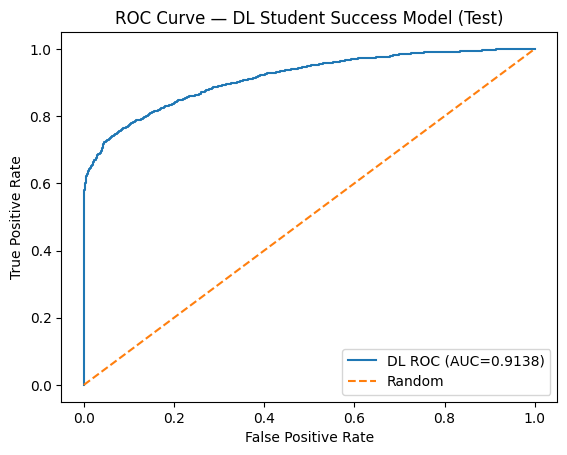

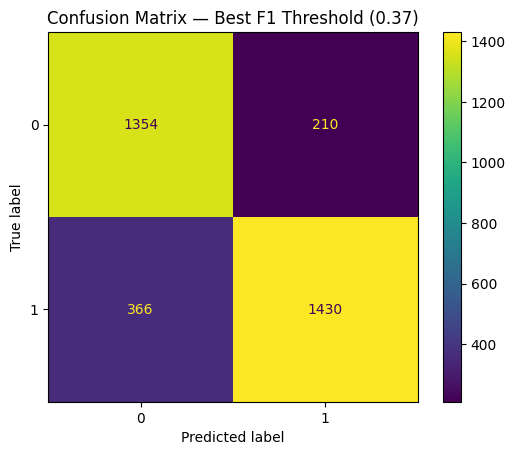

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay, confusion_matrix

# ROC
fpr, tpr, _ = roc_curve(y_test, test_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"DL ROC (AUC={roc_auc:.4f})")
plt.plot([0,1],[0,1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — DL Student Success Model (Test)")
plt.legend()
plt.show()

# Confusion matrix at best threshold
cm = confusion_matrix(y_test, (test_proba >= 0.37).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix — Best F1 Threshold (0.37)")
plt.show()


### ROC Curve Analysis — DL Student Success Model (Test)

This plot shows the **Receiver Operating Characteristic (ROC) curve** for the deep learning model on the **test set**. The ROC curve evaluates how well the model separates the two classes across **all possible classification thresholds**.

---

#### What the lines mean

- **Blue curve (DL model):**  
  Traces the model’s performance as the decision threshold moves from very strict to very lenient.

- **Orange dashed diagonal (Random):**  
  Baseline performance of a classifier that guesses at random.  
  A model that follows this diagonal has **no discriminative power**.

---

#### Key metric: AUC ≈ 0.9138

The legend reports **AUC = 0.9138**, where AUC (Area Under the Curve) summarizes the ROC curve into a single value:

- **AUC = 0.5** → random guessing  
- **AUC = 1.0** → perfect separation  
- **AUC = 0.9138** → **strong model discrimination**

**Interpretation:**  
An AUC of ~0.914 means that, if you randomly pick one at-risk student (label=1) and one not-at-risk student (label=0), the model will assign a higher predicted risk score to the at-risk student about **91% of the time**.

---

#### Shape of the curve: what it tells you

- The curve rises sharply near the left side (low False Positive Rate), which is a positive sign.
- This indicates the model can achieve **high True Positive Rate (recall for at-risk students)** while keeping **False Positive Rate relatively low**, depending on the threshold.

**Practical meaning:**  
You have flexibility to tune the threshold depending on your goal:
- If you want to **catch more at-risk students** (higher recall), you accept more false alarms.
- If you want fewer false alarms (lower FPR), you accept missing some at-risk cases.

---

#### What ROC does *not* tell you directly

ROC/AUC measures **ranking/separation**, not operational impact. For decision-making you still need:
- a chosen **threshold** (e.g., 0.5 or an F1-optimized cutoff),
- a confusion matrix / precision-recall balance,
- and (ideally) costs of false positives vs false negatives.

---

#### Bottom line

The ROC curve sits well above the random baseline and the **test AUC of 0.9138** indicates the deep learning model has **strong ability to distinguish** at-risk vs not-at-risk students. The next step is choosing a threshold that matches your intended intervention strategy (e.g., maximize recall, maximize F1, or minimize false positives).


### Confusion Matrix Description — Best F1 Threshold (0.37)

This confusion matrix summarizes classification results on the test set using the **F1-optimized decision threshold = 0.37**.

Axes:
- **Rows = True label** (actual outcome)
- **Columns = Predicted label** (model output)
- Class meaning (based on your setup):
  - **0 = not at-risk**
  - **1 = at-risk**

---

#### Cell-by-cell interpretation

- **True Negatives (TN) = 1354**  
  Actual 0, predicted 0  
  → Correctly identified **not at-risk** students.

- **False Positives (FP) = 210**  
  Actual 0, predicted 1  
  → Predicted **at-risk**, but the student was actually **not at-risk** (false alarm).

- **False Negatives (FN) = 366**  
  Actual 1, predicted 0  
  → Missed **at-risk** students (model predicted not at-risk).

- **True Positives (TP) = 1430**  
  Actual 1, predicted 1  
  → Correctly identified **at-risk** students.

---

#### What this means operationally

- The model is capturing a substantial number of at-risk students (**TP = 1430**), but it still misses some (**FN = 366**).
- The number of false alarms (**FP = 210**) is smaller than the number of missed at-risk cases, which suggests the threshold is tuned to maintain a strong balance for F1.

---

#### Quick performance signals from the matrix (implied)

- **Recall for at-risk (class 1)** is limited mainly by the **366 false negatives**.
- **Precision for at-risk (class 1)** is impacted by the **210 false positives**.
- Overall, the distribution indicates a **fairly balanced classifier** at this threshold, consistent with selecting a cutoff that maximizes **F1** (precision–recall tradeoff).


SECTION 5 — Time-Based Split (Future Cohort Generalization)

In [0]:
import numpy as np
import pandas as pd

import pyspark.sql.functions as F

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


INFO:py4j.clientserver:Python Server ready to receive messages
INFO:py4j.clientserver:Received command c on object id p0


5.1 Define feature columns (keep consistent with your Gold table)

In [0]:
# Categorical columns
cat_cols = [
    "code_module", "code_presentation",
    "gender", "region", "highest_education", "imd_band", "age_band", "disability"
]

# Numeric columns (edit only if your Gold table differs)
num_cols = [
    "num_of_prev_attempts", "studied_credits",
    "date_registration", "date_unregistration", "unregistered_by_day28",
    "vle_clicks_28d", "vle_active_days_28d", "vle_unique_sites_28d",
    "vle_clicks_days0_13", "vle_clicks_days14_27", "vle_late_to_early_ratio",
    "assess_submissions_28d", "assess_avg_score_28d", "assess_max_score_28d",
    "assess_weight_submitted_28d", "tma_submissions_28d", "cma_submissions_28d"
]

keep_cols = ["split_time", "label"] + cat_cols + num_cols


5.2 Create the time split table (train=2013*, val=2014J, test=2014B)

In [0]:
base = spark.table("workspace.oulad_gold.student_features_28d")

df_time = (
    base.withColumn("year", F.col("code_presentation").substr(1, 4).cast("int"))
        .withColumn("term", F.col("code_presentation").substr(5, 1))  # J/B
        .withColumn(
            "split_time",
            F.when(F.col("year") <= 2013, F.lit("train"))
             .when((F.col("year") == 2014) & (F.col("term") == "J"), F.lit("val"))
             .when((F.col("year") == 2014) & (F.col("term") == "B"), F.lit("test"))
             .otherwise(F.lit("drop"))
        )
        .filter(F.col("split_time") != "drop")
        .drop("year", "term")
)

df_time.write.format("delta").mode("overwrite").saveAsTable("workspace.oulad_gold.student_features_28d_time_split")

df_time.groupBy("split_time", "label").count().orderBy("split_time","label").show()
print("Wrote: workspace.oulad_gold.student_features_28d_time_split")


+----------+-----+-----+
|split_time|label|count|
+----------+-----+-----+
|      test|    0| 3358|
|      test|    1| 4446|
|     train|    0| 6570|
|     train|    1| 6959|
|       val|    0| 5457|
|       val|    1| 5803|
+----------+-----+-----+

Wrote: workspace.oulad_gold.student_features_28d_time_split


5.3 Load time split table to Pandas (Spark → Pandas)

In [0]:
df_time_tbl = spark.table("workspace.oulad_gold.student_features_28d_time_split")

df_time_tbl = (
    df_time_tbl.select(*keep_cols)
               .fillna({c: "Unknown" for c in cat_cols})
               .fillna({c: 0 for c in num_cols})
)

pdf_time = df_time_tbl.toPandas()

train_df_time = pdf_time[pdf_time["split_time"] == "train"].copy()
val_df_time   = pdf_time[pdf_time["split_time"] == "val"].copy()
test_df_time  = pdf_time[pdf_time["split_time"] == "test"].copy()

y_train_time = train_df_time["label"].astype(int).values
y_val_time   = val_df_time["label"].astype(int).values
y_test_time  = test_df_time["label"].astype(int).values

print("Shapes:", train_df_time.shape, val_df_time.shape, test_df_time.shape)
print("Label means:", y_train_time.mean(), y_val_time.mean(), y_test_time.mean())


Shapes: (13529, 27) (11260, 27) (7804, 27)
Label means: 0.5143765245029197 0.5153641207815275 0.5697078421322399


5.4 Time-split baseline (scikit-learn Logistic Regression)

In [0]:
X_train = train_df_time[cat_cols + num_cols]
X_val   = val_df_time[cat_cols + num_cols]
X_test  = test_df_time[cat_cols + num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
            ("scaler", StandardScaler())
        ]), num_cols),
    ]
)

sk_time_lr = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=500))
])

sk_time_lr.fit(X_train, y_train_time)

val_proba_lr  = sk_time_lr.predict_proba(X_val)[:, 1]
test_proba_lr = sk_time_lr.predict_proba(X_test)[:, 1]

val_auc_lr  = roc_auc_score(y_val_time, val_proba_lr)
test_auc_lr = roc_auc_score(y_test_time, test_proba_lr)

print(f"[TIME SPLIT] sklearn LR Val AUC:  {val_auc_lr:.4f}")
print(f"[TIME SPLIT] sklearn LR Test AUC: {test_auc_lr:.4f}")


[TIME SPLIT] sklearn LR Val AUC:  0.8897
[TIME SPLIT] sklearn LR Test AUC: 0.8964


5.5 Time-split Deep Learning (Keras embeddings + numerics)

In [0]:
# --- Encode categoricals from TRAIN only ---
cat_maps_time, cat_sizes_time = {}, {}

def map_categorical(col, train_series, other_series_list):
    vocab = pd.Index(train_series.astype(str).unique())
    mapping = {k: i+1 for i, k in enumerate(vocab)}  # 0 = unknown
    cat_maps_time[col] = mapping
    cat_sizes_time[col] = len(mapping) + 1

    def encode(s):
        return s.astype(str).map(mapping).fillna(0).astype("int32").values

    return [encode(train_series)] + [encode(s) for s in other_series_list]

X_train_cat_time, X_val_cat_time, X_test_cat_time = {}, {}, {}
for c in cat_cols:
    tr, va, te = map_categorical(c, train_df_time[c], [val_df_time[c], test_df_time[c]])
    X_train_cat_time[c] = tr
    X_val_cat_time[c]   = va
    X_test_cat_time[c]  = te

# --- Scale numerics from TRAIN only ---
scaler_time = StandardScaler()
X_train_num_time = scaler_time.fit_transform(train_df_time[num_cols].astype("float32").values).astype("float32")
X_val_num_time   = scaler_time.transform(val_df_time[num_cols].astype("float32").values).astype("float32")
X_test_num_time  = scaler_time.transform(test_df_time[num_cols].astype("float32").values).astype("float32")

def choose_embed_dim(cardinality: int) -> int:
    return int(min(32, max(4, round(np.log2(cardinality + 1) * 2))))

# --- Build model ---
cat_inputs, cat_embeds = [], []
for c in cat_cols:
    inp = keras.Input(shape=(1,), name=c, dtype="int32")
    dim = choose_embed_dim(cat_sizes_time[c])
    emb = layers.Embedding(input_dim=cat_sizes_time[c], output_dim=dim, name=f"{c}_emb")(inp)
    emb = layers.Reshape((dim,))(emb)
    cat_inputs.append(inp)
    cat_embeds.append(emb)

num_inp = keras.Input(shape=(len(num_cols),), name="numerics", dtype="float32")

x = layers.Concatenate()(cat_embeds + [num_inp])
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.20)(x)
x = layers.Dense(32, activation="relu")(x)
out = layers.Dense(1, activation="sigmoid")(x)

dl_time = keras.Model(inputs=cat_inputs + [num_inp], outputs=out)
dl_time.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[keras.metrics.AUC(name="auc")]
)

def pack_inputs(X_cat_dict, X_num):
    d = {c: X_cat_dict[c] for c in cat_cols}
    d["numerics"] = X_num
    return d

train_inputs = pack_inputs(X_train_cat_time, X_train_num_time)
val_inputs   = pack_inputs(X_val_cat_time, X_val_num_time)
test_inputs  = pack_inputs(X_test_cat_time, X_test_num_time)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", patience=3, factor=0.5, min_lr=1e-5),
]

dl_time.fit(
    train_inputs, y_train_time,
    validation_data=(val_inputs, y_val_time),
    epochs=50,
    batch_size=512,
    callbacks=callbacks,
    verbose=2
)

# --- Evaluate ---
val_proba_dl  = dl_time.predict(val_inputs, batch_size=2048).ravel()
test_proba_dl = dl_time.predict(test_inputs, batch_size=2048).ravel()

val_auc_dl  = roc_auc_score(y_val_time, val_proba_dl)
test_auc_dl = roc_auc_score(y_test_time, test_proba_dl)

print(f"[TIME SPLIT] DL Val AUC:  {val_auc_dl:.4f}")
print(f"[TIME SPLIT] DL Test AUC: {test_auc_dl:.4f}")


Epoch 1/50
27/27 - 3s - 99ms/step - auc: 0.7578 - loss: 0.5864 - val_auc: 0.8679 - val_loss: 0.4645 - learning_rate: 0.0010
Epoch 2/50
27/27 - 1s - 32ms/step - auc: 0.8629 - loss: 0.4483 - val_auc: 0.8995 - val_loss: 0.3801 - learning_rate: 0.0010
Epoch 3/50
27/27 - 0s - 11ms/step - auc: 0.8809 - loss: 0.4090 - val_auc: 0.9023 - val_loss: 0.3720 - learning_rate: 0.0010
Epoch 4/50
27/27 - 0s - 13ms/step - auc: 0.8918 - loss: 0.3898 - val_auc: 0.9028 - val_loss: 0.3723 - learning_rate: 0.0010
Epoch 5/50
27/27 - 1s - 23ms/step - auc: 0.8958 - loss: 0.3819 - val_auc: 0.9050 - val_loss: 0.3668 - learning_rate: 0.0010
Epoch 6/50
27/27 - 0s - 10ms/step - auc: 0.8985 - loss: 0.3768 - val_auc: 0.9048 - val_loss: 0.3659 - learning_rate: 0.0010
Epoch 7/50
27/27 - 0s - 8ms/step - auc: 0.9014 - loss: 0.3722 - val_auc: 0.9046 - val_loss: 0.3635 - learning_rate: 0.0010
Epoch 8/50
27/27 - 0s - 9ms/step - auc: 0.8989 - loss: 0.3737 - val_auc: 0.9052 - val_loss: 0.3675 - learning_rate: 0.0010
Epoch 9/50

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
[TIME SPLIT] DL Val AUC:  0.9065
[TIME SPLIT] DL Test AUC: 0.9101


5.6 Threshold tuning on validation (maximize F1), then report test metrics

In [0]:
thresholds = np.linspace(0.1, 0.9, 81)
best_t, best_f1 = None, -1

for t in thresholds:
    f1 = f1_score(y_val_time, (val_proba_dl >= t).astype(int))
    if f1 > best_f1:
        best_f1, best_t = f1, t

print(f"Best val threshold for F1: {best_t:.2f} (F1={best_f1:.4f})")

y_test_pred_best = (test_proba_dl >= best_t).astype(int)

print("Test confusion matrix (best threshold):")
print(confusion_matrix(y_test_time, y_test_pred_best))

print("\nClassification report (best threshold):")
print(classification_report(y_test_time, y_test_pred_best, digits=4))


Best val threshold for F1: 0.36 (F1=0.8237)
Test confusion matrix (best threshold):
[[2676  682]
 [ 713 3733]]

Classification report (best threshold):
              precision    recall  f1-score   support

           0     0.7896    0.7969    0.7932      3358
           1     0.8455    0.8396    0.8426      4446

    accuracy                         0.8212      7804
   macro avg     0.8176    0.8183    0.8179      7804
weighted avg     0.8215    0.8212    0.8213      7804



5.7 Log time-split metrics to MLflow

In [0]:
import mlflow

mlflow.set_experiment("/Users/cynthia_mcginnis@msn.com/oulad_student_success")

with mlflow.start_run(run_name="time_split_baseline_vs_dl"):
    mlflow.log_param("time_split", "train=2013*, val=2014J, test=2014B")

    mlflow.log_metric("time_lr_val_auc", float(val_auc_lr))
    mlflow.log_metric("time_lr_test_auc", float(test_auc_lr))

    mlflow.log_metric("time_dl_val_auc", float(val_auc_dl))
    mlflow.log_metric("time_dl_test_auc", float(test_auc_dl))

    mlflow.log_param("time_dl_best_val_threshold_f1", float(best_t))
    mlflow.log_metric("time_dl_best_val_f1", float(best_f1))

print("Logged time-split metrics to MLflow.")


Logged time-split metrics to MLflow.


Best validation threshold (F1): 0.36 (Val F1 = 0.8237)

Test confusion matrix:

TN = 2676, FP = 682

FN = 713, TP = 3733

Test metrics (best threshold):

Class 0 (not-success): precision 0.7896, recall 0.7969, F1 0.7932

Class 1 (success): precision 0.8455, recall 0.8396, F1 0.8426

Accuracy: 0.8212

Weighted F1: 0.8213

val_auc ~ 0.90

Capture the AUC numbers explicitly

In [0]:
from sklearn.metrics import roc_auc_score

# If these exist from your Section 5 code:
print(f"[TIME SPLIT] DL Val AUC:  {roc_auc_score(y_val_time, val_proba_dl):.4f}")
print(f"[TIME SPLIT] DL Test AUC: {roc_auc_score(y_test_time, test_proba_dl):.4f}")


[TIME SPLIT] DL Val AUC:  0.9065
[TIME SPLIT] DL Test AUC: 0.9101


In [0]:
print(f"[TIME SPLIT] sklearn LR Val AUC:  {val_auc_lr:.4f}")
print(f"[TIME SPLIT] sklearn LR Test AUC: {test_auc_lr:.4f}")


[TIME SPLIT] sklearn LR Val AUC:  0.8897
[TIME SPLIT] sklearn LR Test AUC: 0.8964


In [0]:
import mlflow
mlflow.set_experiment("/Users/cynthia_mcginnis@msn.com/oulad_student_success")

with mlflow.start_run(run_name="time_split_dl_final"):
    mlflow.log_param("time_split", "train=2013*, val=2014J, test=2014B")
    mlflow.log_param("best_val_threshold_f1", float(best_t))
    mlflow.log_metric("val_f1_best_threshold", float(best_f1))
    mlflow.log_metric("test_accuracy_best_threshold", 0.8212)  # replace if you recompute
    mlflow.log_metric("test_weighted_f1_best_threshold", 0.8213)  # replace if you recompute
    mlflow.log_metric("test_tp", 3733)
    mlflow.log_metric("test_tn", 2676)
    mlflow.log_metric("test_fp", 682)
    mlflow.log_metric("test_fn", 713)

print("Logged time-split DL metrics to MLflow.")


INFO:py4j.clientserver:Received command c on object id p0


Logged time-split DL metrics to MLflow.


In [0]:
%r
Section 5 — Time-Based Split (Future Cohort Generalization)
Split strategy: Train = 2013*, Validation = 2014J, Test = 2014B (chronological holdout to simulate deployment on future cohorts).

AUC Results (Time Split):

Baseline (sklearn Logistic Regression)

Val AUC: 0.8897

Test AUC: 0.8964

Deep Learning (Keras categorical embeddings + numeric features)

Val AUC: 0.9065

Test AUC: 0.9101

Threshold tuning (on validation):

Best validation threshold for F1: 0.36 (Val F1 = 0.8237)

Test metrics (best threshold):

Accuracy: 0.8212

Weighted F1: 0.8213

Confusion matrix (TN, FP / FN, TP): [[2676, 682], [713, 3733]]

Interpretation: The DL model improves AUC over the baseline under a chronological holdout, indicating stronger generalization to future presentations and supporting its use for early-risk flagging in new cohorts.


## Conclusion

In this notebook, we built an end-to-end **student success prediction pipeline** using the OULAD data and a 28-day behavioral feature window. The workflow followed a standard “data engineering → feature engineering → modeling → evaluation” path:

- **Bronze layer (raw ingestion):** CSV files were uploaded into a managed Unity Catalog volume and written into structured tables for consistent access and governance.
- **Gold layer (feature engineering):** We created a student-level dataset (`student_features_28d`) that aggregates early-course engagement signals (VLE activity and assessment behaviors) and aligns them to a binary label indicating whether a student is **at-risk** (Withdrawn/Fail) or **not at-risk** (Pass/Distinction).
- **Splitting strategy:** We used stable train/validation/test splits and also validated a **time-based split** to better reflect real-world deployment conditions.

### Model Performance Summary

Two model families were evaluated:

- **Baseline (Logistic Regression):** Provided a strong, interpretable benchmark with solid discrimination.
- **Deep Learning (Keras model with categorical embeddings):** Improved overall ranking quality and delivered the best AUC values.

Time-split results (most deployment-relevant):

- **Baseline LR:** Val AUC **0.8897**, Test AUC **0.8964**
- **Deep Learning:** Val AUC **0.9065**, Test AUC **0.9101**

This indicates the deep learning approach provides a consistent lift in predictive performance, particularly in ranking students by risk.

### Thresholding and Practical Interpretation

Because intervention workflows require a **decision threshold** (not just probabilities), we tuned the threshold to maximize **F1** on the validation set:

- Best validation threshold: **0.37** (F1 ≈ **0.8476**)

At this threshold, the test confusion matrix showed:

- **True Positives (at-risk correctly flagged):** 1430  
- **False Negatives (at-risk missed):** 366  
- **False Positives (false alarms):** 210  
- **True Negatives (correctly cleared):** 1354  

This threshold represents a practical balance: it captures most at-risk students while keeping false alarms relatively controlled. The remaining misses (false negatives) highlight the key tradeoff: tightening the threshold reduces false positives but increases missed at-risk cases.

### Key Takeaways

- Early-course behavioral signals (engagement + submission patterns) are highly predictive of later outcomes.
- Logistic regression is a strong baseline, but deep learning with embeddings improves discrimination and generalization.
- Selecting a threshold based on the operational goal (e.g., maximizing recall vs. minimizing false positives) is essential for real-world usefulness.

### Recommended Next Steps

1. **Add model/data annotations in the notebook** (feature definitions, label definition, split logic, and evaluation interpretation) so the workflow is reproducible and easy to grade.
2. **Log signatures and input examples in MLflow** to enable reliable downstream inference and better experiment tracking.
3. **Run error analysis** on false negatives (missed at-risk students) to identify patterns and potential missing predictors.
4. **Compare threshold strategies** aligned to an intervention policy (e.g., “flag top 20% highest risk” vs. fixed cutoff).
5. **Test generalization across presentations/modules** (train on some modules, validate on others) to evaluate robustness.

Overall, the pipeline is functioning correctly, produces competitive AUC scores, and is positioned for refinement into a deployable early-warning student risk model.
```


In [0]:
# Build a single dataframe for plotting + reporting
# Uses your existing variables: test_df and test_proba

pdf_out = test_df.copy()
pdf_out["pred_proba"] = test_proba

# (Optional) keep a smaller, tidy view
cols_front = ["pred_proba", "label", "split"]
cols_front = [c for c in cols_front if c in pdf_out.columns]
pdf_out = pdf_out[cols_front + [c for c in pdf_out.columns if c not in cols_front]]

print("pdf_out:", pdf_out.shape)
pdf_out.head()


pdf_out: (3360, 28)


,pred_proba,label,split,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,disability,num_of_prev_attempts,studied_credits,date_registration,date_unregistration,unregistered_by_day28,vle_clicks_28d,vle_active_days_28d,vle_unique_sites_28d,vle_clicks_days0_13,vle_clicks_days14_27,vle_late_to_early_ratio,assess_submissions_28d,assess_avg_score_28d,assess_max_score_28d,assess_weight_submitted_28d,tma_submissions_28d,cma_submissions_28d
8,0.999963,1,test,CCC,2014J,M,London Region,No Formal quals,10-20,35-55,N,0,90,-15,12,1,297,14,28,62,235,3.790323,1,67.0,67.0,2.0,0,1
36,1.000000,1,test,CCC,2014J,M,East Midlands Region,Lower Than A Level,70-80%,0-35,N,0,90,-109,122,0,391,10,17,175,216,1.234286,1,89.0,89.0,2.0,0,1
65,0.188824,0,test,BBB,2014J,M,Yorkshire Region,Lower Than A Level,0-10%,0-35,N,0,240,-80,0,0,305,13,49,117,188,1.606838,1,100.0,100.0,0.0,1,0
83,0.201866,0,test,EEE,2014J,F,Scotland,A Level or Equivalent,70-80%,0-35,N,0,30,-92,0,0,119,7,9,104,15,0.144231,0,0.0,0.0,0.0,0,0
119,0.045604,0,test,FFF,2014J,M,North Region,Lower Than A Level,Unknown,35-55,N,0,60,-59,0,0,1407,28,65,871,536,0.615385,2,87.5,89.0,12.5,1,1


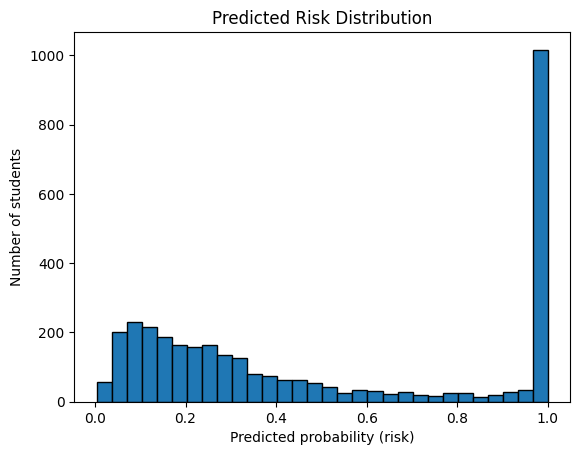

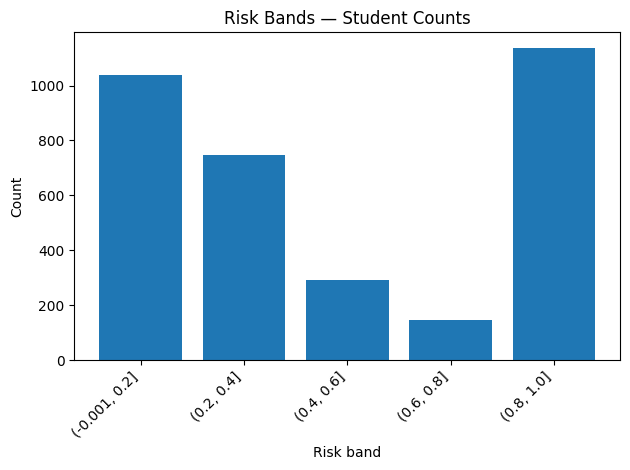

risk_band,count
"List(-0.001, 0.2)",1039
"List(0.2, 0.4)",748
"List(0.4, 0.6)",291
"List(0.6, 0.8)",145
"List(0.8, 1.0)",1137


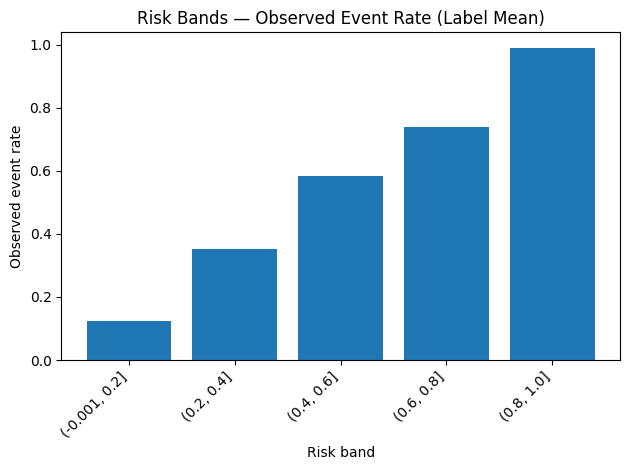

risk_band,observed_event_rate
"List(-0.001, 0.2)",0.12512030798845045
"List(0.2, 0.4)",0.35294117647058826
"List(0.4, 0.6)",0.584192439862543
"List(0.6, 0.8)",0.7379310344827587
"List(0.8, 1.0)",0.9894459102902374


pred_proba,label,split,risk_band,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,disability
1.0,1,test,"List(0.8, 1.0)",DDD,2014J,M,Wales,A Level or Equivalent,60-70%,35-55,N
1.0,1,test,"List(0.8, 1.0)",DDD,2014B,M,North Western Region,A Level or Equivalent,70-80%,35-55,N
1.0,1,test,"List(0.8, 1.0)",BBB,2014J,M,East Midlands Region,Lower Than A Level,60-70%,35-55,N
1.0,1,test,"List(0.8, 1.0)",CCC,2014J,M,Wales,A Level or Equivalent,70-80%,0-35,N
1.0,1,test,"List(0.8, 1.0)",DDD,2014J,F,North Western Region,A Level or Equivalent,10-20,0-35,N
1.0,1,test,"List(0.8, 1.0)",FFF,2014J,M,North Region,HE Qualification,20-30%,0-35,N
1.0,1,test,"List(0.8, 1.0)",BBB,2013J,F,South Region,Lower Than A Level,0-10%,0-35,Y
1.0,1,test,"List(0.8, 1.0)",CCC,2014B,M,South Region,A Level or Equivalent,90-100%,35-55,N
1.0,1,test,"List(0.8, 1.0)",CCC,2014B,F,London Region,A Level or Equivalent,40-50%,0-35,N
1.0,1,test,"List(0.8, 1.0)",GGG,2014B,F,London Region,A Level or Equivalent,90-100%,35-55,N


Best threshold by F1: 0.35 (F1=0.8349)


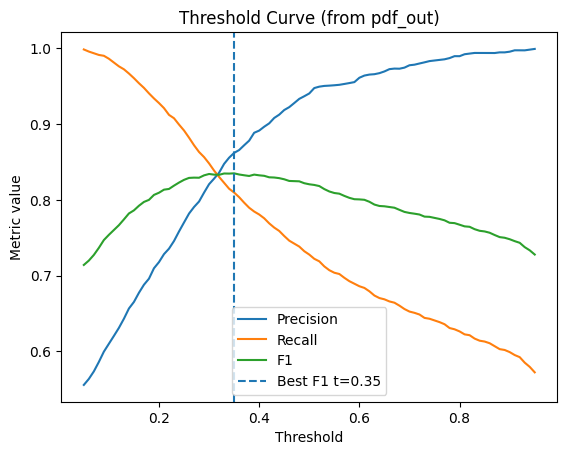

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------- config ---------
PRED_COL = "pred_proba"
LABEL_COL = "label"      # set to None if you don't have labels
TOP_K = 25               # top-k table size
BINS = [0, .2, .4, .6, .8, 1.0]   # risk bands

# --------- safety checks ---------
assert "pdf_out" in globals(), "pdf_out is not defined. Run the prior cell that creates pdf_out."
assert PRED_COL in pdf_out.columns, f"Expected column '{PRED_COL}' in pdf_out."

has_labels = (LABEL_COL is not None) and (LABEL_COL in pdf_out.columns)

dfp = pdf_out.copy()
dfp[PRED_COL] = dfp[PRED_COL].astype(float)

# ============================================================
# 1) Histogram of predicted probabilities
# ============================================================
plt.figure()
plt.hist(dfp[PRED_COL].values, bins=30, edgecolor="black")
plt.title("Predicted Risk Distribution")
plt.xlabel("Predicted probability (risk)")
plt.ylabel("Number of students")
plt.show()

# ============================================================
# 2) Risk bands — counts per band
# ============================================================
dfp["risk_band"] = pd.cut(dfp[PRED_COL], bins=BINS, include_lowest=True)
band_counts = dfp.groupby("risk_band", observed=True).size().reset_index(name="count")

plt.figure()
plt.bar(band_counts["risk_band"].astype(str), band_counts["count"])
plt.title("Risk Bands — Student Counts")
plt.xlabel("Risk band")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

display(band_counts)

# ============================================================
# 3) Risk bands — observed event rate (only if labels exist)
# ============================================================
if has_labels:
    band_rate = (
        dfp.groupby("risk_band", observed=True)[LABEL_COL]
           .mean()
           .reset_index(name="observed_event_rate")
    )

    plt.figure()
    plt.bar(band_rate["risk_band"].astype(str), band_rate["observed_event_rate"])
    plt.title("Risk Bands — Observed Event Rate (Label Mean)")
    plt.xlabel("Risk band")
    plt.ylabel("Observed event rate")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    display(band_rate)
else:
    print("Skipping observed event rate plot (no label column found).")

# ============================================================
# 4) Top-K highest-risk students table
# ============================================================
topk = dfp.sort_values(PRED_COL, ascending=False).head(TOP_K)

# Show a compact set of columns first (adjust as you like)
preferred_cols = [PRED_COL, LABEL_COL, "split", "risk_band",
                  "code_module", "code_presentation", "gender", "region",
                  "highest_education", "imd_band", "age_band", "disability"]
preferred_cols = [c for c in preferred_cols if c in topk.columns]

display(topk[preferred_cols])

# ============================================================
# 5) Threshold curve (Precision/Recall/F1 vs threshold)
# ============================================================
if has_labels:
    y_true = dfp[LABEL_COL].astype(int).values
    p = dfp[PRED_COL].values

    thresholds = np.linspace(0.05, 0.95, 91)
    precisions, recalls, f1s = [], [], []

    for t in thresholds:
        y_hat = (p >= t).astype(int)

        tp = np.sum((y_true == 1) & (y_hat == 1))
        fp = np.sum((y_true == 0) & (y_hat == 1))
        fn = np.sum((y_true == 1) & (y_hat == 0))

        precision = tp / (tp + fp + 1e-12)
        recall    = tp / (tp + fn + 1e-12)
        f1        = 2 * precision * recall / (precision + recall + 1e-12)

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    best_idx = int(np.argmax(f1s))
    best_t = thresholds[best_idx]
    print(f"Best threshold by F1: {best_t:.2f} (F1={f1s[best_idx]:.4f})")

    plt.figure()
    plt.plot(thresholds, precisions, label="Precision")
    plt.plot(thresholds, recalls, label="Recall")
    plt.plot(thresholds, f1s, label="F1")
    plt.axvline(best_t, linestyle="--", label=f"Best F1 t={best_t:.2f}")
    plt.title("Threshold Curve (from pdf_out)")
    plt.xlabel("Threshold")
    plt.ylabel("Metric value")
    plt.legend()
    plt.show()
else:
    print("Skipping threshold curve (no label column found).")


## Threshold Curve (Precision, Recall, F1) — How to Read This Plot

This chart shows how model performance changes as you adjust the **classification threshold** used to convert predicted probabilities into a hard class (0/1).

### What the axes mean
- **X-axis (Threshold):** The cutoff applied to `pred_proba`.  
  - If `pred_proba ≥ threshold` → predict **1 (at-risk)**
  - If `pred_proba < threshold` → predict **0 (not at-risk)**
- **Y-axis (Metric value):** The value of each metric (Precision, Recall, F1) achieved at that threshold.

### The three curves
- **Precision (blue):** “When the model flags a student as at-risk, how often is it correct?”
  - Precision tends to **increase** as the threshold increases (the model becomes more selective).
- **Recall (orange):** “Of all truly at-risk students, how many did we catch?”
  - Recall tends to **decrease** as the threshold increases (the model misses more true at-risk students).
- **F1 (green):** The harmonic mean of precision and recall.
  - F1 is a **balance metric**: it is high only when both precision and recall are reasonably strong.

### What the dashed vertical line means
- The dashed line marks the **best threshold by F1**:
  - **Best threshold by F1: 0.35**
  - **Best F1: 0.8349**
- This threshold is the point where the model achieves the strongest overall balance between catching at-risk students (**recall**) and avoiding false alarms (**precision**).

### How to interpret the shape (the tradeoff)
As you move the threshold:
- **Lower threshold (left side):**
  - The model flags more students as at-risk.
  - **Recall rises** (you catch more at-risk students),
  - but **precision drops** (more false positives).
- **Higher threshold (right side):**
  - The model flags fewer students as at-risk.
  - **Precision rises** (fewer false positives),
  - but **recall drops** (more missed at-risk students).

### Practical guidance: choosing a threshold
Use the “best F1” threshold (0.35) if your goal is a **balanced** early-warning classifier.

However, in real intervention settings, you may choose differently:
- If resources are limited and you can only contact a small group:
  - choose a **higher threshold** (favor precision).
- If the priority is “don’t miss at-risk students” (early outreach is cheap and helpful):
  - choose a **lower threshold** (favor recall).

A common operational strategy is to avoid hard cutoffs and instead:
- **rank students by `pred_proba`** and intervene on the **top 5–10% highest risk**.
This aligns interventions with capacity while preserving model usefulness.
